In [6]:
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
from scipy.stats import bernoulli, binom
import seaborn as sns
from scipy import stats 
from psmpy.functions import cohenD
from psmpy.plotting import *

In [7]:
# Helper functions for plotting

def quick_plot_2(dataset,variable,variable2,variable3):
  plt.figure(figsize=(15,8))
  #Density plots for treatment and control
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==0) & (nsw[variable3]==1)])
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==1) & (nsw[variable3]==0)])
  sns.kdeplot(dataset=dataset[variable][(dataset[variable2]==0) & (nsw[variable3]==0)])
  return 

def quick_mean_sd(dataset):
  nsw_teatment_subsample = dataset[dataset['treat']==1]
  nsw_control_subsample = dataset[dataset['treat']==0]
  treatment_subsample_mean_sd = nsw_teatment_subsample.describe().loc[['mean','std']].T
  control_subsample_mean_sd = nsw_control_subsample.describe().loc[['mean','std']].T
  treat_control_comparison = pd.concat([treatment_subsample_mean_sd, control_subsample_mean_sd], axis=1)
  superlables = {'treated':['mean','sd'],'control':['mean','sd']}
  treat_control_comparison.columns = pd.MultiIndex.from_frame(pd.DataFrame(superlables).melt())
  return print(treat_control_comparison)
  
def quick_plot(dataset,var1,var2):
  plt.figure(figsize=(15,8))
  #Density plots for treatment and control
  g1 = sns.kdeplot(data=dataset[var1][dataset[var2]==1],color = 'firebrick',label= str(var2)+'_1')
  g1 = sns.kdeplot(data=dataset[var1][dataset[var2]==0],color = 'forestgreen',label= str(var2)+'_0')
  plt.legend(fontsize=15)
  return 


# 1 - Load data sets 

In [8]:
'''
Load all datasets.
nsw = Male sub sample of treated and control units as used by Lalonde (1986).
nswre74  = Further subsample extracted by Dehejia and Wahba (1999) which includes information on earnings in 1974 (re74)

cps1 = full Current Population Survey dataset
cps2 , cps3 and cps4 are further subsamples exctracted by lalonde to with distributions which better match the nsw treated group.

psid1 = full Panel Study of Income Dynamics dataset
psid2,psid3,psid4 are again subsamples extracted by Lalonde 

'''
# experimental data 

nsw = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nsw.dta")
nsw.drop('data_id', axis=1, inplace=True)
nswre74_control = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_control.xls')
nswre74_treated = pd.read_excel('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/nswre74_treated.xlsx')
nswre74 = pd.concat([nswre74_control,nswre74_treated],axis=0,ignore_index=True) #Combine treatment into a single control as pandas dataframe

# non experimental data (cps)

cps = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/cps_controls.dta")
cps.drop('data_id', axis=1, inplace=True)

#cps['treat'] == 0 # created treated column
#load non experimental data (psid)

psid = pd.read_stata("/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/psid_controls.dta")
psid.drop('data_id', axis=1, inplace=True)

# reset indexes

nsw = nsw.reset_index(drop=True)
nswre74 = nswre74.reset_index(drop=True)
cps = cps.reset_index(drop=True)
psid = psid.reset_index(drop=True)

# Exploratory Analysis

### Plotting functions

In [9]:
import scipy.stats as stat
import pylab 
from tueplots import axes, bundles , figsizes, fonts,fontsizes

#### Q-Q plot
def plot_data(df,feature,title):
    # neat plot 
    plt.rcParams.update({"figure.dpi": 150}) 
    plt.rcParams.update(bundles.neurips2022())
    plt.rcParams.update(fonts.neurips2022())
    plt.rcParams.update(axes.tick_direction( y="in"))
    plt.rcParams.update(axes.color(base="black"))
    plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=2))
    #historigram
    plt.figure(figsize=(4,3))
    plt.subplot(1,2,1)
    plt.grid(color='white', axis='y')
    plt.grid(color='white', axis='x')
    plt.tick_params(right='on')
    plt.tick_params(left='on')
    plt.tick_params(top='on')
    plt.title("Histogram")
    df[feature].hist(bins=20)
    #qq plot 
    plt.subplot(1,2,2)
    plt.grid(color='white', axis='y')
    plt.grid(color='white', axis='x')
    stat.probplot(df[feature],dist='norm',plot=pylab)
    plt.suptitle(title)
    plt.show()

In [10]:
import matplotlib.gridspec as gridspec

class SeabornFigToGrid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [11]:
nsw[nsw['treat']==1].describe()
nsw[nsw['treat']==0].describe()

treat         age   education       black    hispanic     married  \
count  425.0  425.000000  425.000000  425.000000  425.000000  425.000000   
mean     0.0   24.447059   10.188235    0.800000    0.112941    0.157647   
std      0.0    6.590276    1.618686    0.400471    0.316894    0.364839   
min      0.0   17.000000    3.000000    0.000000    0.000000    0.000000   
25%      0.0   19.000000    9.000000    1.000000    0.000000    0.000000   
50%      0.0   23.000000   10.000000    1.000000    0.000000    0.000000   
75%      0.0   28.000000   11.000000    1.000000    0.000000    0.000000   
max      0.0   55.000000   14.000000    1.000000    1.000000    1.000000   

         nodegree          re75          re78  
count  425.000000    425.000000    425.000000  
mean     0.814118   3026.682861   5090.047852  
std      0.389470   5201.246582   5718.085938  
min      0.000000      0.000000      0.000000  
25%      1.000000      0.000000      0.000000  
50%      1.000000    823.254395   3746.700928  
75%      1.000000   3649.769043   8329.823242  
max      1.000000  36941.269531  39483.531250

In [7]:
nswre74[nswre74['treat']==1].describe()
nswre74[nswre74['treat']==0].describe()

treat         age   education       black    hispanic     married  \
count  260.0  260.000000  260.000000  260.000000  260.000000  260.000000   
mean     0.0   25.053846   10.088462    0.826923    0.107692    0.153846   
std      0.0    7.057745    1.614325    0.379043    0.310589    0.361497   
min      0.0   17.000000    3.000000    0.000000    0.000000    0.000000   
25%      0.0   19.000000    9.000000    1.000000    0.000000    0.000000   
50%      0.0   24.000000   10.000000    1.000000    0.000000    0.000000   
75%      0.0   28.000000   11.000000    1.000000    0.000000    0.000000   
max      0.0   55.000000   14.000000    1.000000    1.000000    1.000000   

         nodegree          re74          re75          re78  
count  260.000000    260.000000    260.000000    260.000000  
mean     0.834615   2107.026658   1266.909002   4554.801126  
std      0.372244   5687.905694   3102.982044   5483.835991  
min      0.000000      0.000000      0.000000      0.000000  
25%      1.000000      0.000000      0.000000      0.000000  
50%      1.000000      0.000000      0.000000   3138.795500  
75%      1.000000    139.424700    650.096475   7288.420000  
max      1.000000  39570.680000  23031.980000  39483.530000

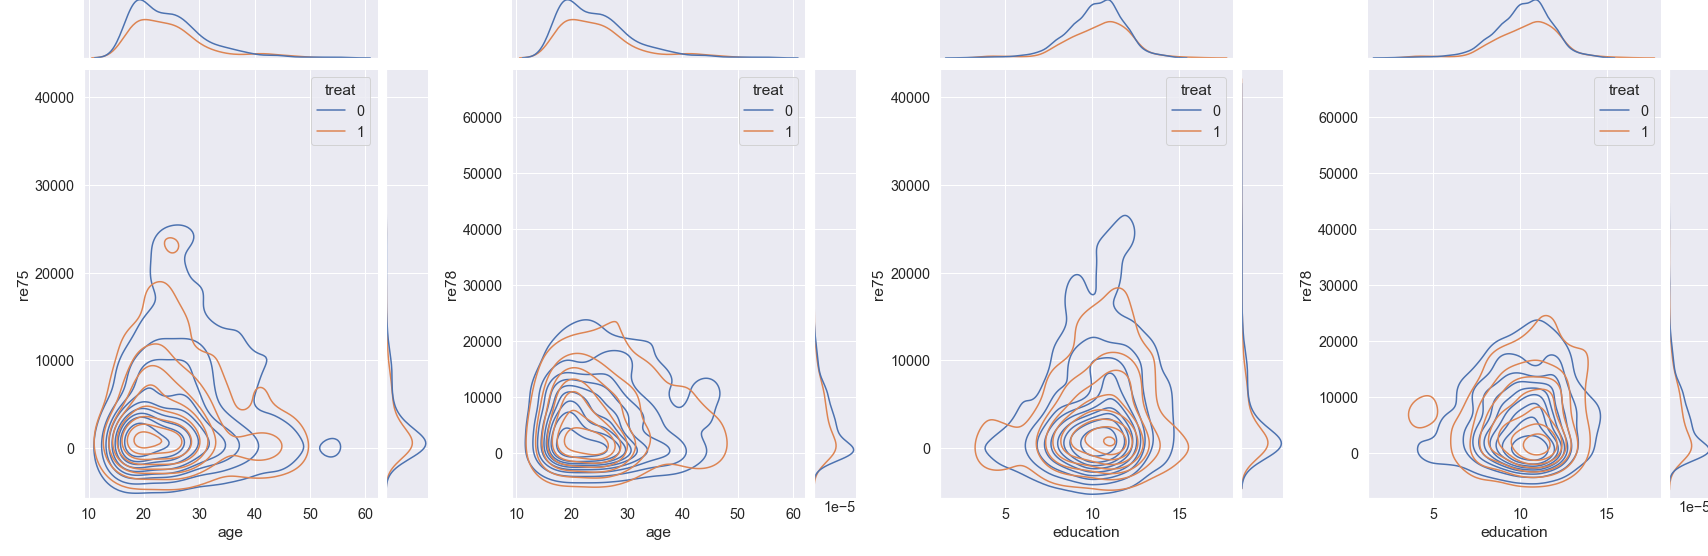

In [12]:
# Joint distributions
sns.set_style('darkgrid')

plot_kind = 'kde'
hue = 'treat'


g0 = sns.jointplot(data= nsw,x="age",y="re75", hue= hue, kind=plot_kind)
g1 = sns.jointplot(data= nsw,x="age",y="re78", hue= hue, kind=plot_kind)
g2 = sns.jointplot(data= nsw,x="education",y="re75", hue= hue, kind=plot_kind)
g3 = sns.jointplot(data= nsw,x="education",y="re78", hue= hue, kind=plot_kind)


fig = plt.figure(figsize=(24,8))
gs = gridspec.GridSpec(1,4)

mg0 = SeabornFigToGrid(g0, fig, gs[0])
mg1 = SeabornFigToGrid(g1, fig, gs[1])
mg2 = SeabornFigToGrid(g2, fig, gs[2])
mg3 = SeabornFigToGrid(g3, fig, gs[3])


gs.tight_layout(fig)


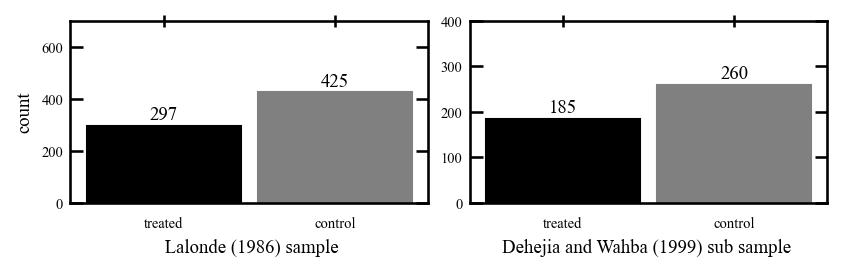

In [14]:
# Plot the balance of classes in the datasets 
from tueplots import axes, bundles , figsizes, fonts,fontsizes

# Lalonde sample 
nswTreated = nsw[nsw['treat']==1]
nswControl = nsw[nsw['treat']==0]
nsw_heights = [len(nswTreated),len(nswControl)]

# Dehejia & Wahba subsample 

nswRe74_Treated = nswre74[nswre74['treat']==1]
nswRe74_Control = nswre74[nswre74['treat']==0]
nswRe74_heights = [len(nswRe74_Treated),len(nswRe74_Control),]

# Update plot paramaters 
fig, ax = plt.subplots(nrows=1, ncols=2)


# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=2))
plt.rcParams.update(fontsizes.neurips2022())

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Lalonde sample  bar plot 

# Lalonde sample
ax[0].set_facecolor('white')
ax[0].grid(color='white', axis='y')
ax[0].grid(color='white', axis='x')
ax[0].set_ylim(0,700)

ax[0].spines['left']
ax[0].spines['bottom']
ax[0].spines['top']

ax[0].tick_params(right='on')
ax[0].tick_params(left='on')
ax[0].tick_params(top='on')

ax[0].set_xlabel(" Lalonde (1986) sample")
ax[0].set_ylabel("count")

bar = ax[0].bar(['treated','control'],nsw_heights,width = 0.9)
# colour chart 
bar[1].set_color('grey')
bar[0].set_color('black')

# Add counts to bar chart - lalonde sample 
for rect in ax[0].patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax[0].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Dehejia & Wahba subsample  bar plot 

ax[1].set_facecolor('white')
ax[1].grid(color='white', axis='y')
ax[1].grid(color='white', axis='x')
ax[1].set_ylim(0,400)

ax[1].spines['left']
ax[1].spines['bottom']
ax[1].spines['top']

bar2 = ax[1].bar(['treated','control'],nswRe74_heights, width = 0.9)

# colour chart 
bar2[1].set_color('grey')
bar2[0].set_color('black')
ax[1].set_xlabel("Dehejia and Wahba (1999) sub sample ")

# tick mark paramaters 
ax[1].tick_params(right='on')
ax[1].tick_params(left='on')
ax[1].tick_params(top='on')


 # Add counts to bar chart - dehejia wahba sample 
for rect in ax[1].patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax[1].annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')   

# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Save and display 
plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig1_classImbalance_bar_chart.png', bbox_inches='tight')
plt.show()


<p> outliers </p>

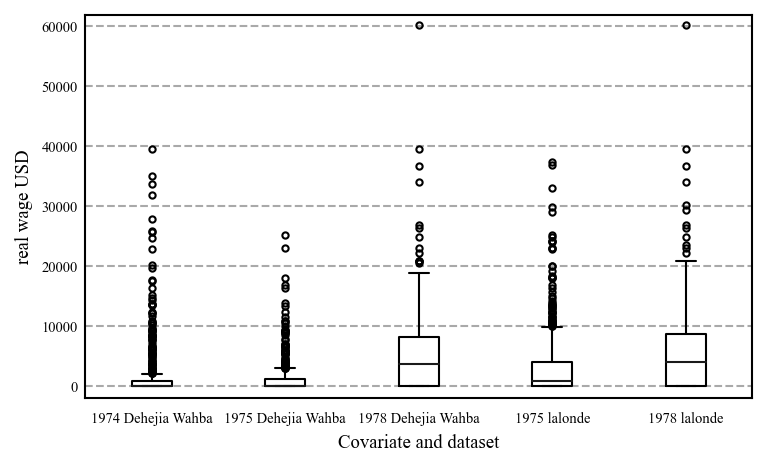

In [16]:
from tueplots import bundles 
fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}

wage74_dej = nswre74['re74']
wage75_dej = nswre74['re75']
wage78_dej = nswre74['re78']

wage75_lalonde = nsw['re75']
wage78_lalonde = nsw['re78']

ax.boxplot([wage74_dej,wage75_dej,wage78_dej,wage75_lalonde,wage78_lalonde],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

ax.set_xlim(0.5,5.5)
ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5],['1974 Dehejia Wahba', '1975 Dehejia Wahba','1978 Dehejia Wahba','1975 lalonde','1978 lalonde'])

ax.set_xlabel('Covariate and dataset')
ax.set_ylabel('real wage USD')


plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/appendix plots/appendix1_wage_boxplots.png', bbox_inches='tight')
plt.show()

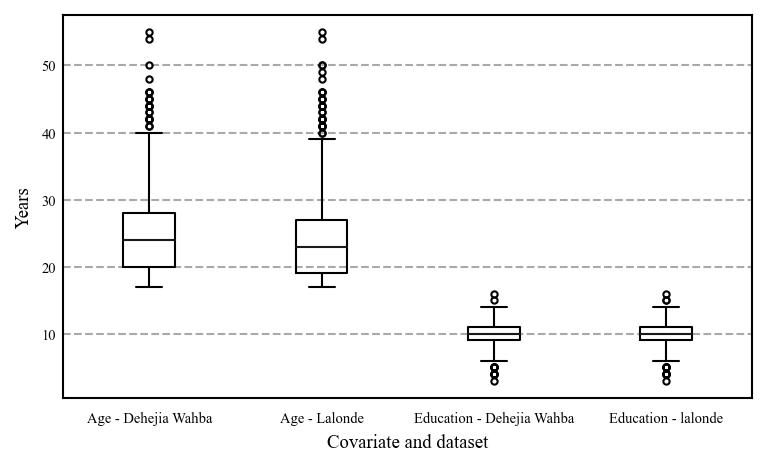

In [17]:
fig, ax = plt.subplots(figsize=(5, 3))
# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}

Age_lalonde = nsw['age']
Educ_lalonde = nsw['education']

Age_dej = nswre74['age']
Educ_dej = nswre74['education']



ax.boxplot([Age_dej,Age_lalonde,Educ_dej,Educ_lalonde],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4],['Age - Dehejia Wahba', 'Age - Lalonde','Education - Dehejia Wahba','Education - lalonde'])


ax.set_xlabel('Covariate and dataset')
ax.set_ylabel('Years')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/appendix plots/appendix2_age_educ_boxplots.png', bbox_inches='tight')

plt.show()



<p> Outliers for CPS and PSID </p>

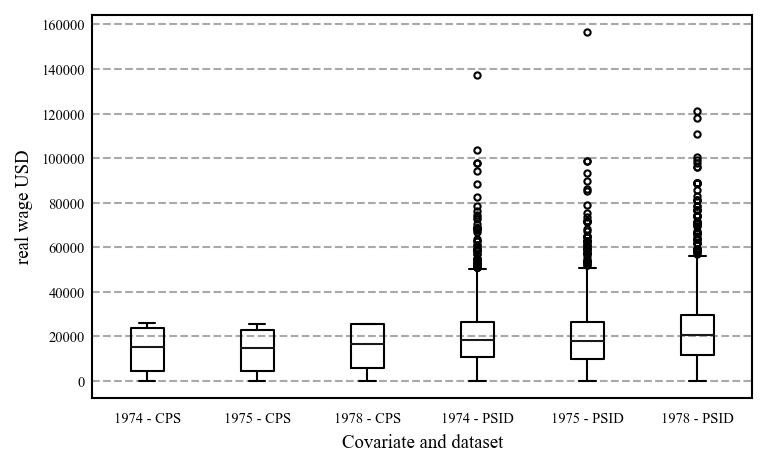

In [18]:
fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}

wage74_cps = cps['re74']
wage75_cps = cps['re75']
wage78_cps = cps['re78']

wage74_psid = psid['re74']
wage75_psid = psid['re75']
wage78_psid = psid['re78']

ax.boxplot([wage74_cps,wage75_cps,wage78_cps,wage74_psid,wage75_psid,wage78_psid],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5,6],['1974 - CPS', '1975 - CPS','1978 - CPS','1974 - PSID','1975 - PSID','1978 - PSID'])

ax.set_xlabel('Covariate and dataset')
ax.set_ylabel('real wage USD')


plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/appendix plots/appendix3_wage_boxplots_cps_psid.png', bbox_inches='tight')
plt.show()

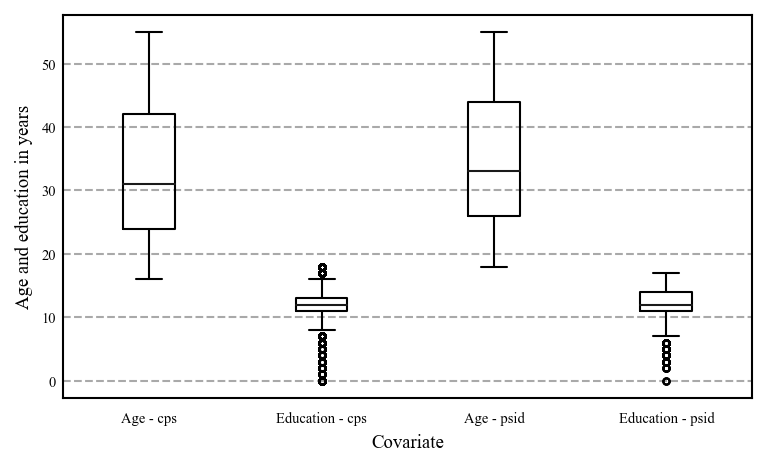

In [19]:
# Age and education 

fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=4))
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}


Age_cps = cps['age']
Educ_cps = cps['education']

Age_psid = psid['age']
Educ_psid = psid['education']

ax.boxplot([Age_cps,Educ_cps,Age_psid,Educ_psid],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4],['Age - cps', 'Education - cps','Age - psid','Education - psid'])

ax.set_xlabel('Covariate')

ax.set_ylabel('Age and education in years')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/appendix plots/appendix4_age_educ_cpspsid_boxplots.png', bbox_inches='tight')

plt.show()

### Remove outliers, transform variables and store dataset

In [20]:
# Drop outliers 
cols = ['re75','re78','age','education'] 
cols2 = ['re74','re75','re78','age','education'] 

lower_bound = 0.5
upper_bound = 0.95

Q1_1 = nsw[cols].quantile(lower_bound)
Q3_1 = nsw[cols].quantile(upper_bound)
IQR_1 = Q3_1 - Q1_1

Q1_2 = nswre74[cols2].quantile(lower_bound)
Q3_2 = nswre74[cols2].quantile(upper_bound)
IQR_2 = Q3_2 - Q1_2

Q1_3 = cps[cols2].quantile(lower_bound)
Q3_3 = cps[cols2].quantile(upper_bound)
IQR_3 = Q3_3 - Q1_3

Q1_4 = psid[cols2].quantile(lower_bound)
Q3_4 = psid[cols2].quantile(upper_bound)
IQR_4 = Q3_4 - Q1_4

nsw = nsw[~((nsw[cols] < (Q1_1 -  IQR_1)) |(nsw[cols] > (Q3_1 +  IQR_1))).any(axis=1)]

nswre74 = nswre74[~((nswre74[cols2] < (Q1_2 -  IQR_2)) |(nswre74[cols2] > (Q3_2 +  IQR_2))).any(axis=1)]

cps = cps[~((cps[cols] < (Q1_3 - IQR_3)) |(cps[cols2] > (Q3_3 +  IQR_3))).any(axis=1)]
psid = psid[~((psid[cols2] < (Q1_4 - IQR_4)) |(psid[cols2] > (Q3_4 + IQR_4))).any(axis=1)]

/var/folders/sp/c9zy568j6s94zqs20ynd8pz00000gn/T/ipykernel_54548/4241450747.py:28: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  cps = cps[~((cps[cols] < (Q1_3 - IQR_3)) |(cps[cols2] > (Q3_3 +  IQR_3))).any(axis=1)]


### Key points 
<p> 1. Taking logs of wage reveals that the distribution is bimodal </p>
<p> ---- There are a group of low wage earners (o mode) and higher wave earns (around 8 mode) </p>
<p> ---- Treatment decreases amount of low wage earns, increases amount of high wave earners</p>

In [21]:
# Define function for feature transformation 
def feature_tranform(dataset):
    # account for integer overflow - convert features will tranform to 64bit type integer

    dataset['re75'] = dataset['re75'].astype(int)
    dataset['re78'] = dataset['re78'].astype(int)
    dataset['age'] = dataset['age'].astype(int)
    dataset['education'] = dataset['education'].astype(int) 

    warnings.filterwarnings('ignore')

    if 're74' in dataset.columns: 
        dataset['re74'] = dataset['re74'].astype(int)  
        warnings.filterwarnings('ignore')
    else:
        pass

    # Keep a copy of education as numerical 
    dataset['education*'] = dataset['education']

    # Generate dummy variables 
    dataset['u75'] = (dataset['re75'] == 0).astype(int)
    # Generate interaction terms 
    dataset['educ_re75'] = dataset['education']*dataset['re75']
    dataset['hisp_u75'] = dataset['hispanic']*dataset['u75']
    dataset['black_u75'] = dataset['black']*dataset['u75']
    
    if 're74' in dataset.columns: 
        dataset['u74'] = (dataset['re74'] == 0).astype(int)
        dataset['educ_re74'] = dataset['education']*dataset['re74']
        dataset['hisp_u74'] = dataset['hispanic']*dataset['u74']
        dataset['black_u74'] = dataset['black']*dataset['u74']
    else:
        pass    

    # Change zeroes to in wage as logs struggle
    dataset['re78'][dataset['re78'] == 0] = 1
    dataset['re75'][dataset['re75'] == 0] = 1

    if 're74' in dataset.columns:
        dataset['re74'][dataset['re74'] == 0] = 1
    else:
        pass     
        
    # squared variables
    dataset['agesq'] = dataset['age']*dataset['age']
    dataset['re78sq'] = dataset['re78']*dataset['re78']
    dataset['re75sq'] = dataset['re75']*dataset['re75']
    dataset['educsq'] = dataset['education']*dataset['education']

    if 're74' in dataset.columns:
        dataset['re74sq'] = dataset['re74']*dataset['re74']
    else:
        pass      

    # boxcox transforms of varibles
    dataset['ageboxcox'],parameters=stat.boxcox(dataset['age']) 
    dataset['re78boxcox'],parameters=stat.boxcox(dataset['re78'])
    dataset['re75boxcox'],parameters=stat.boxcox(dataset['re75'])

    if 're74' in dataset.columns:
        dataset['re74boxcox'],parameters=stat.boxcox(dataset['re74'])
    else:
        pass     
    # natural log of wage
    dataset['lnre78'] = np.log(dataset['re78'])
    dataset['lnre75'] = np.log(dataset['re75'])

    if 're74' in dataset.columns:
        dataset['lnre74'] = np.log(dataset['re74'])
    else:
        pass 

        # Change zeroes to in wage as logs struggle
    dataset['re78'][dataset['re78'] == 1] = 0
    dataset['re75'][dataset['re75'] == 1] = 0

    if 're74' in dataset.columns:
        dataset['re74'][dataset['re74'] == 1] = 0
    else:
        pass    

    # encode education as binary indicator variable 
    dataset = pd.get_dummies(dataset, columns=["education"],drop_first=True)
    
    return dataset  

In [22]:
# Combine lalonde treated units with cps and psid groups
cps_no_re74 = cps.drop(['re74'],axis=1)   # drop wage in 1974 from cps comparison
psid_no_re74 = psid.drop(['re74'],axis=1) # drop wage in 1974 from psid comparison

# Create quasi-experimental datasets 
Quasi_NswCps_lalonde_ = pd.concat([nsw[nsw['treat']==1],cps_no_re74],ignore_index=True)
Quasi_NswPsid_lalonde_ = pd.concat([nsw[nsw['treat']==1],psid_no_re74],ignore_index=True)
Quasi_NswCps_dehWab_ = pd.concat([nswre74[nswre74['treat']==1],cps],ignore_index=True)
Quasi_NswPsid_dehWab_ = pd.concat([nswre74[nswre74['treat']==1],psid], ignore_index=True)

# Pass data sets through feature transformation function 
Quasi_NswCps_lalonde = feature_tranform(Quasi_NswCps_lalonde_)
Quasi_NswPsid_lalonde = feature_tranform(Quasi_NswPsid_lalonde_)
Quasi_NswCps_dehWab = feature_tranform(Quasi_NswCps_dehWab_)
Quasi_NswPsid_dehWab = feature_tranform(Quasi_NswPsid_dehWab_)

In [23]:
Quasi_NswCps_lalonde

treat  age  black  hispanic  married  nodegree   re75   re78  \
0        1.0   37    1.0       0.0      1.0       1.0      0   9930   
1        1.0   22    0.0       1.0      0.0       1.0      0   3595   
2        1.0   30    1.0       0.0      0.0       0.0      0  24909   
3        1.0   27    1.0       0.0      0.0       1.0      0   7506   
4        1.0   33    1.0       0.0      0.0       1.0      0    289   
...      ...  ...    ...       ...      ...       ...    ...    ...   
10148    0.0   27    0.0       0.0      1.0       0.0  25243  25564   
10149    0.0   55    0.0       0.0      1.0       1.0  25243  21463   
10150    0.0   48    0.0       0.0      1.0       1.0  25243  25564   
10151    0.0   47    0.0       0.0      1.0       1.0  11384  13671   
10152    0.0   40    0.0       0.0      0.0       1.0  13144   7979   

       education*  u75  ...  education_9  education_10  education_11  \
0              11    1  ...            0             0             1   
1               9    1  ...            1             0             0   
2              12    1  ...            0             0             0   
3              11    1  ...            0             0             1   
4               8    1  ...            0             0             0   
...           ...  ...  ...          ...           ...           ...   
10148          13    0  ...            0             0             0   
10149           9    0  ...            1             0             0   
10150          10    0  ...            0             1             0   
10151           9    0  ...            1             0             0   
10152          10    0  ...            0             1             0   

       education_12  education_13  education_14  education_15  education_16  \
0                 0             0             0             0             0   
1                 0             0             0             0             0   
2                 1             0             0             0             0   
3                 0             0             0             0             0   
4                 0             0             0             0             0   
...             ...           ...           ...           ...           ...   
10148             0             1             0             0             0   
10149             0             0             0             0             0   
10150             0             0             0             0             0   
10151             0             0             0             0             0   
10152             0             0             0             0             0   

       education_17  education_18  
0                 0             0  
1                 0             0  
2                 0             0  
3                 0             0  
4                 0             0  
...             ...           ...  
10148             0             0  
10149             0             0  
10150             0             0  
10151             0             0  
10152             0             0  

[10153 rows x 33 columns]

In [24]:
Quasi_NswPsid_lalonde

treat  age  black  hispanic  married  nodegree   re75   re78  \
0       1.0   37    1.0       0.0      1.0       1.0      0   9930   
1       1.0   22    0.0       1.0      0.0       1.0      0   3595   
2       1.0   30    1.0       0.0      0.0       0.0      0  24909   
3       1.0   27    1.0       0.0      0.0       1.0      0   7506   
4       1.0   33    1.0       0.0      0.0       1.0      0    289   
...     ...  ...    ...       ...      ...       ...    ...    ...   
2591    0.0   32    0.0       0.0      1.0       1.0  39387  36943   
2592    0.0   47    0.0       0.0      1.0       1.0  33837  38568   
2593    0.0   32    0.0       0.0      1.0       1.0  67137  59109   
2594    0.0   47    0.0       0.0      1.0       1.0  47968  55710   
2595    0.0   40    0.0       0.0      1.0       1.0  55500  53198   

      education*  u75  ...  education_8  education_9  education_10  \
0             11    1  ...            0            0             0   
1              9    1  ...            0            1             0   
2             12    1  ...            0            0             0   
3             11    1  ...            0            0             0   
4              8    1  ...            1            0             0   
...          ...  ...  ...          ...          ...           ...   
2591          10    0  ...            0            0             1   
2592           8    0  ...            1            0             0   
2593           8    0  ...            1            0             0   
2594          10    0  ...            0            0             1   
2595           8    0  ...            1            0             0   

      education_11  education_12  education_13  education_14  education_15  \
0                1             0             0             0             0   
1                0             0             0             0             0   
2                0             1             0             0             0   
3                1             0             0             0             0   
4                0             0             0             0             0   
...            ...           ...           ...           ...           ...   
2591             0             0             0             0             0   
2592             0             0             0             0             0   
2593             0             0             0             0             0   
2594             0             0             0             0             0   
2595             0             0             0             0             0   

      education_16  education_17  
0                0             0  
1                0             0  
2                0             0  
3                0             0  
4                0             0  
...            ...           ...  
2591             0             0  
2592             0             0  
2593             0             0  
2594             0             0  
2595             0             0  

[2596 rows x 32 columns]

In [25]:
Quasi_NswCps_dehWab

treat  age  black  hispanic  married  nodegree   re74   re75   re78  \
0        1.0   37    1.0       0.0      1.0       1.0      0      0   9930   
1        1.0   22    0.0       1.0      0.0       1.0      0      0   3595   
2        1.0   30    1.0       0.0      0.0       0.0      0      0  24909   
3        1.0   27    1.0       0.0      0.0       1.0      0      0   7506   
4        1.0   33    1.0       0.0      0.0       1.0      0      0    289   
...      ...  ...    ...       ...      ...       ...    ...    ...    ...   
10038    0.0   27    0.0       0.0      1.0       0.0  25507  25243  25564   
10039    0.0   55    0.0       0.0      1.0       1.0  25862  25243  21463   
10040    0.0   48    0.0       0.0      1.0       1.0  25862  25243  25564   
10041    0.0   47    0.0       0.0      1.0       1.0  16914  11384  13671   
10042    0.0   40    0.0       0.0      0.0       1.0  13628  13144   7979   

       education*  ...  education_9  education_10  education_11  education_12  \
0              11  ...            0             0             1             0   
1               9  ...            1             0             0             0   
2              12  ...            0             0             0             1   
3              11  ...            0             0             1             0   
4               8  ...            0             0             0             0   
...           ...  ...          ...           ...           ...           ...   
10038          13  ...            0             0             0             0   
10039           9  ...            1             0             0             0   
10040          10  ...            0             1             0             0   
10041           9  ...            1             0             0             0   
10042          10  ...            0             1             0             0   

       education_13  education_14  education_15  education_16  education_17  \
0                 0             0             0             0             0   
1                 0             0             0             0             0   
2                 0             0             0             0             0   
3                 0             0             0             0             0   
4                 0             0             0             0             0   
...             ...           ...           ...           ...           ...   
10038             1             0             0             0             0   
10039             0             0             0             0             0   
10040             0             0             0             0             0   
10041             0             0             0             0             0   
10042             0             0             0             0             0   

       education_18  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
10038             0  
10039             0  
10040             0  
10041             0  
10042             0  

[10043 rows x 41 columns]

In [26]:
Quasi_NswPsid_dehWab

treat  age  black  hispanic  married  nodegree   re74   re75   re78  \
0       1.0   37    1.0       0.0      1.0       1.0      0      0   9930   
1       1.0   22    0.0       1.0      0.0       1.0      0      0   3595   
2       1.0   30    1.0       0.0      0.0       0.0      0      0  24909   
3       1.0   27    1.0       0.0      0.0       1.0      0      0   7506   
4       1.0   33    1.0       0.0      0.0       1.0      0      0    289   
...     ...  ...    ...       ...      ...       ...    ...    ...    ...   
2481    0.0   32    0.0       0.0      1.0       1.0  43103  39387  36943   
2482    0.0   47    0.0       0.0      1.0       1.0  44667  33837  38568   
2483    0.0   32    0.0       0.0      1.0       1.0  47022  67137  59109   
2484    0.0   47    0.0       0.0      1.0       1.0  48197  47968  55710   
2485    0.0   40    0.0       0.0      1.0       1.0  50940  55500  53198   

      education*  ...  education_8  education_9  education_10  education_11  \
0             11  ...            0            0             0             1   
1              9  ...            0            1             0             0   
2             12  ...            0            0             0             0   
3             11  ...            0            0             0             1   
4              8  ...            1            0             0             0   
...          ...  ...          ...          ...           ...           ...   
2481          10  ...            0            0             1             0   
2482           8  ...            1            0             0             0   
2483           8  ...            1            0             0             0   
2484          10  ...            0            0             1             0   
2485           8  ...            1            0             0             0   

      education_12  education_13  education_14  education_15  education_16  \
0                0             0             0             0             0   
1                0             0             0             0             0   
2                1             0             0             0             0   
3                0             0             0             0             0   
4                0             0             0             0             0   
...            ...           ...           ...           ...           ...   
2481             0             0             0             0             0   
2482             0             0             0             0             0   
2483             0             0             0             0             0   
2484             0             0             0             0             0   
2485             0             0             0             0             0   

      education_17  
0                0  
1                0  
2                0  
3                0  
4                0  
...            ...  
2481             0  
2482             0  
2483             0  
2484             0  
2485             0  

[2486 rows x 40 columns]

### Save datasets

In [27]:
Quasi_NswCps_lalonde.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv',header = True,index = False)
Quasi_NswPsid_lalonde.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv',header = True,index = False)
Quasi_NswCps_dehWab.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_dehWab.csv',header = True,index = False)
Quasi_NswPsid_dehWab.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv',header = True,index = False)

# Class imbalance plots for QuasiExperimental datasets 

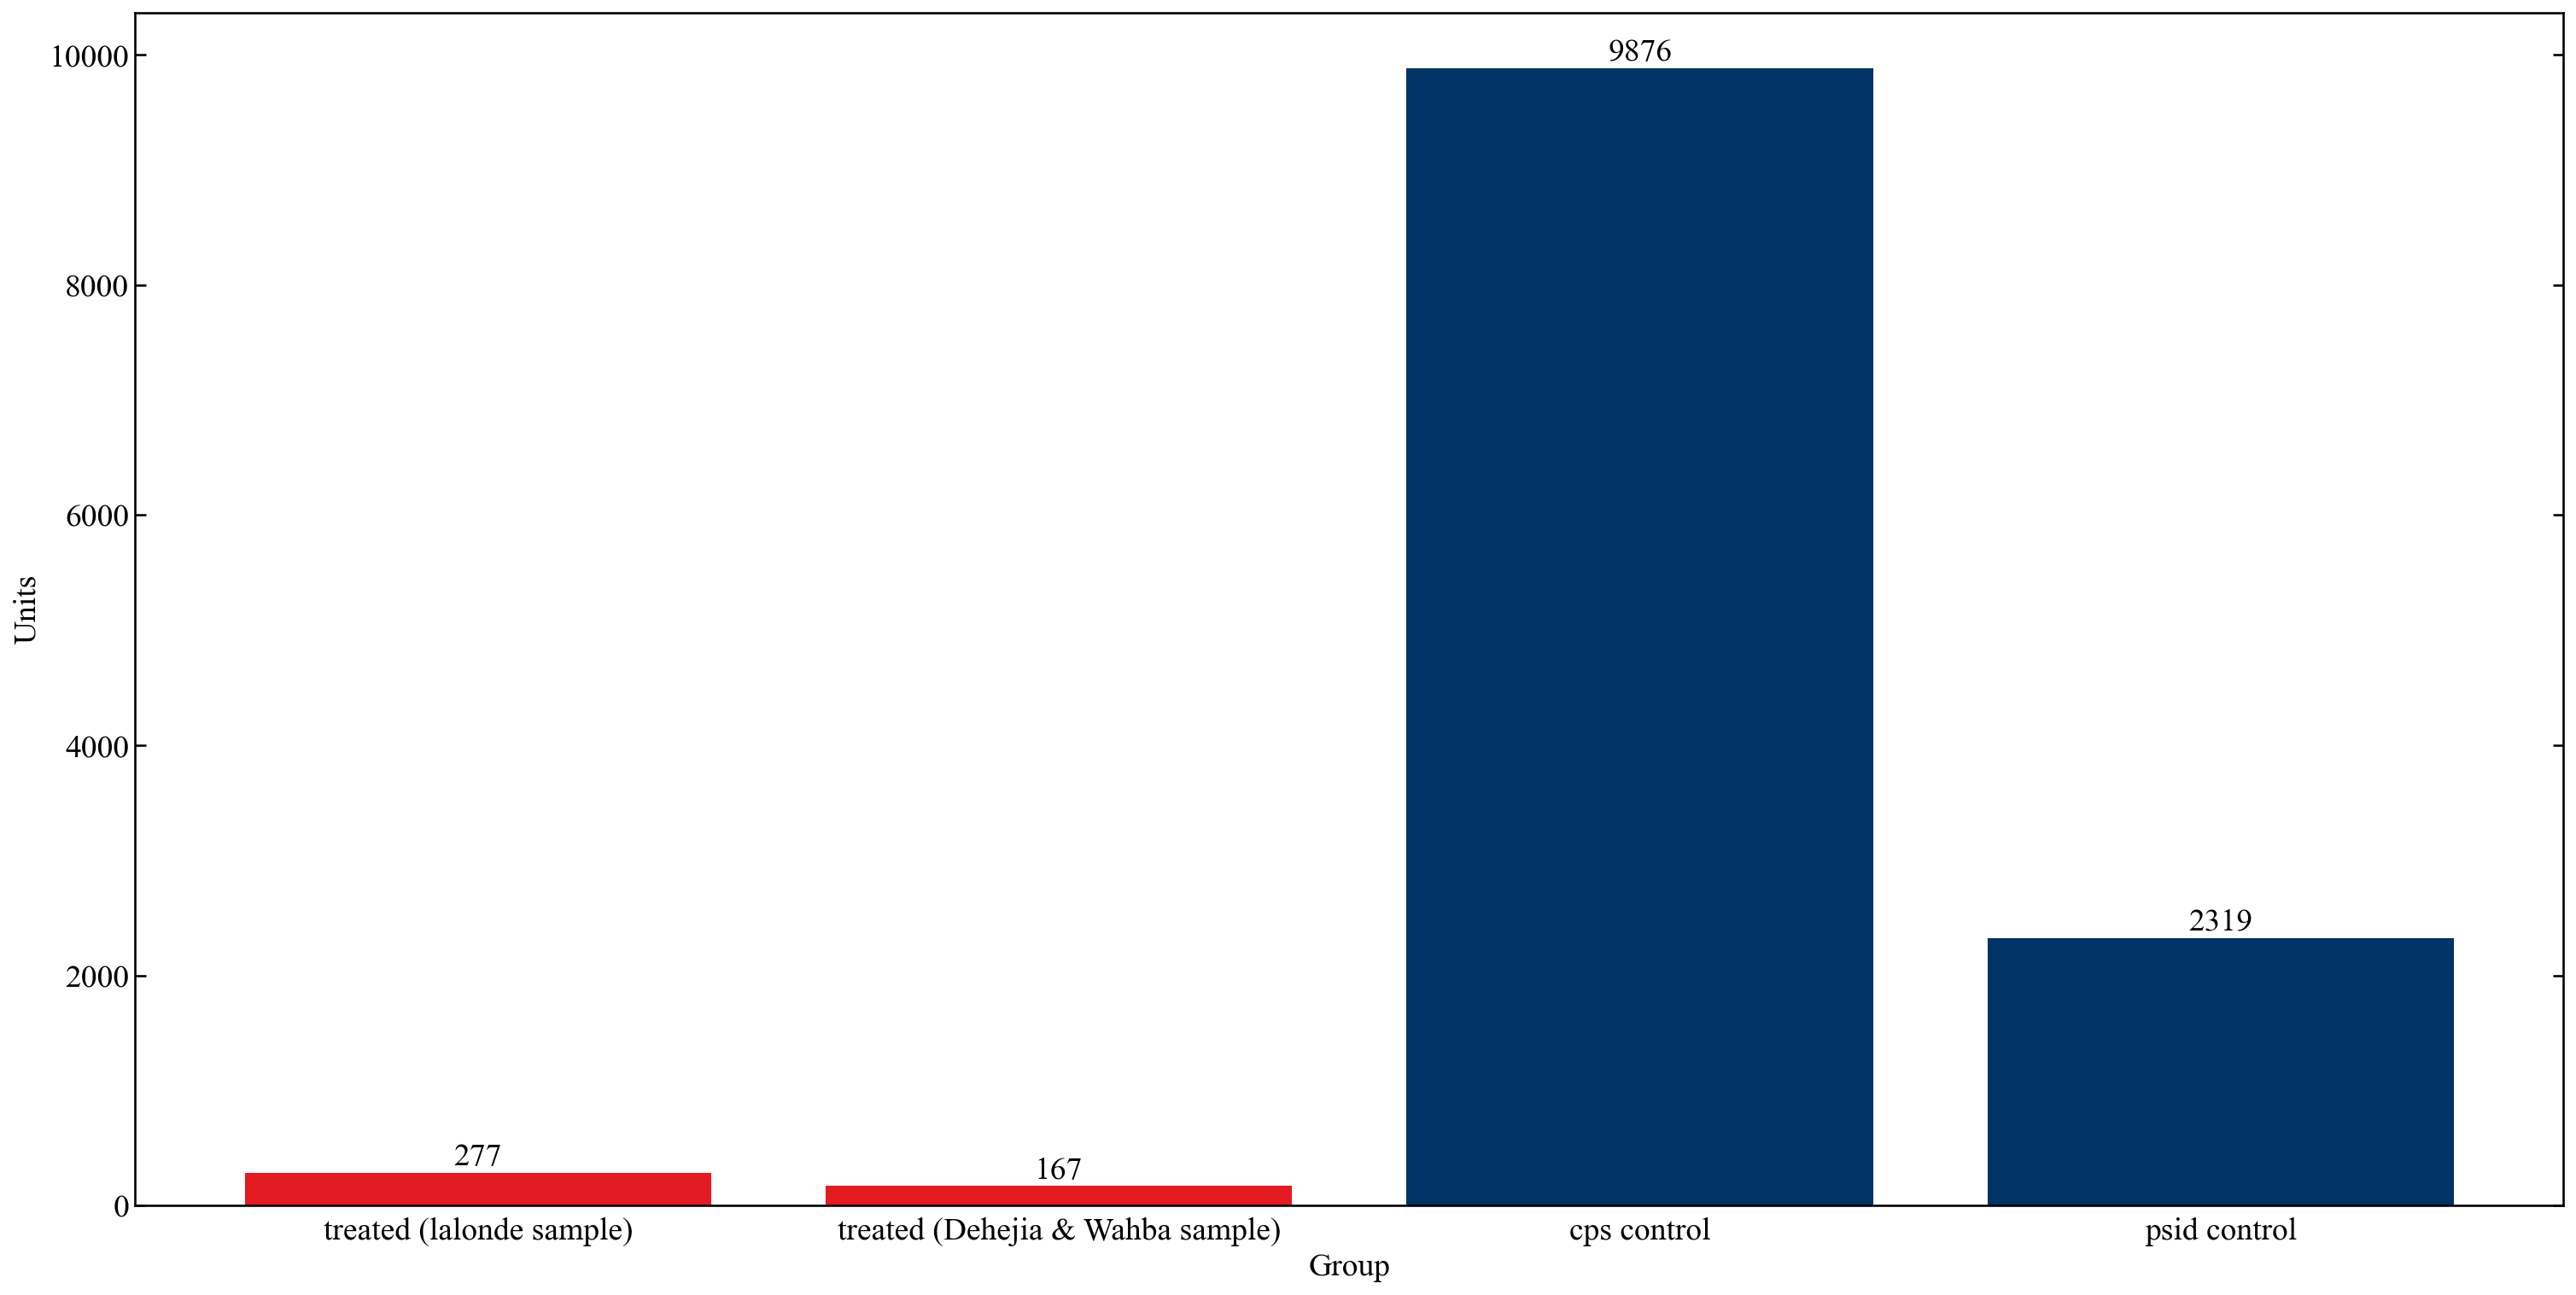

In [28]:
# Plot the balance of classes in the datasets 

# Lalonde sample 
lalondeTreated = Quasi_NswCps_lalonde[Quasi_NswCps_lalonde['treat']==1] # Treated lalonde 
dehWabTreated = Quasi_NswCps_dehWab[Quasi_NswCps_dehWab['treat']==1] # Treated dehWab


cpsControl = Quasi_NswCps_lalonde[Quasi_NswCps_lalonde['treat']==0] # Cps control
psidControl = Quasi_NswPsid_lalonde[Quasi_NswPsid_lalonde['treat']==0] # Psid control

nsw_heights = [len(lalondeTreated),len(dehWabTreated),len(cpsControl),len(psidControl)]

# Update plot paramaters 
fig, ax = plt.subplots(nrows=1, ncols=1,figsize = (20,10))


# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 300}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=1))
#plt.rcParams.update(fontsizes.neurips2022())
plt.rcParams.update({'font.size': 18})
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
# ==== ==== ==== ==== ==== ==== ==== ==== ==== # 
# Lalonde sample  bar plot 

# Lalonde sample
ax.set_facecolor('white')
ax.grid(color='white', axis='y')
ax.grid(color='white', axis='x')
#ax[0].set_ylim(0,700)

ax.spines['left']
ax.spines['bottom']
ax.spines['top']

ax.tick_params(right='on')
ax.tick_params(left='on')
#ax.tick_params(top='on')

ax.set_xlabel("Group")
ax.set_ylabel("Units")

bar = ax.bar(['treated (lalonde sample)','treated (Dehejia & Wahba sample)','cps control','psid control'],nsw_heights,width = 0.8)
# colour chart 
bar[0].set_color('#E31B23')
bar[1].set_color('#E31B23')
bar[2].set_color('#003366')
bar[3].set_color('#003366')

# Add counts to bar chart - lalonde sample 
for rect in ax.patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2
    space = 1
    label = "{:.0f}".format(y_value)
    ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va='bottom')

# Save and display 
plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig1_Quasi_data_classImbalance_bar_chart.png', bbox_inches='tight')
plt.show()

### Smote illustration

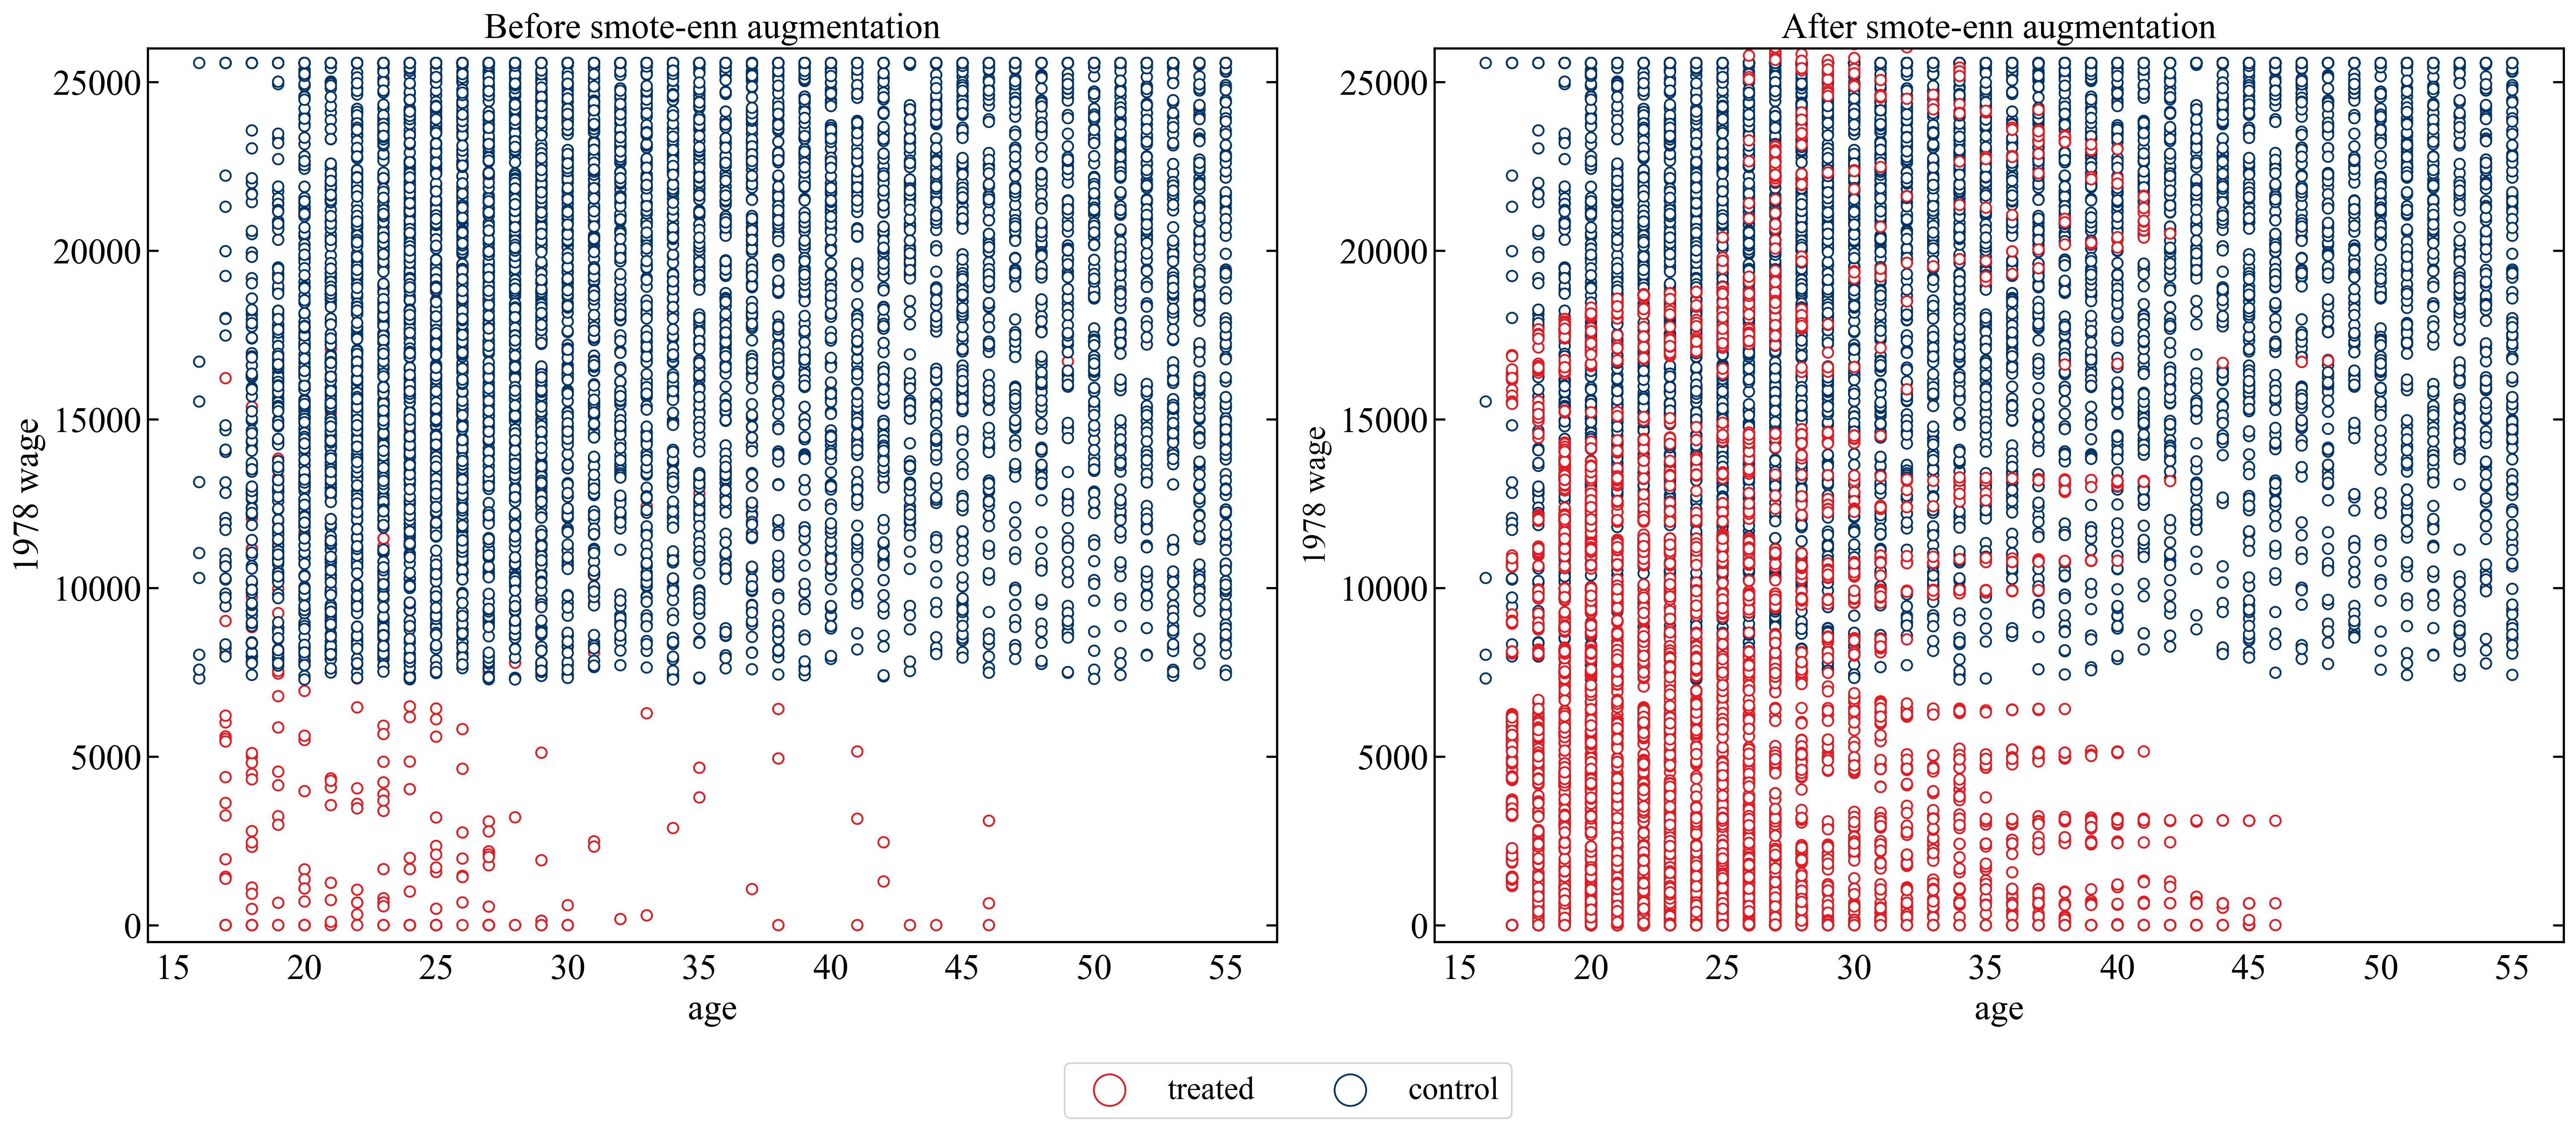

In [29]:
from matplotlib.lines import Line2D
from imblearn.combine import SMOTEENN
resample_demo =SMOTEENN(random_state=0)

#resample data
features, target = resample_demo.fit_resample(Quasi_NswCps_lalonde.drop('treat', axis=1), Quasi_NswCps_lalonde['treat'])	
Quasi_NswCps_lalonde_smote = pd.concat([features,target],axis=1)

color= ['#E31B23' if l == 1 else '#003366' for l in Quasi_NswCps_lalonde['treat']]
color2= ['#E31B23' if l == 1 else '#003366' for l in Quasi_NswCps_lalonde_smote['treat']]


# Update plot paramaters 
fig, ax = plt.subplots(nrows=1, ncols=2,figsize = (20,8))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 300}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022(nrows=1, ncols=1))
#plt.rcParams.update(fontsizes.neurips2022())
plt.rcParams.update({'font.size': 18})

ax[0].set_facecolor('white')
ax[0].grid(color='white', axis='y')
ax[0].grid(color='white', axis='x')
ax[0].spines['left']
ax[0].spines['bottom']
ax[0].spines['top']
ax[0].tick_params(right='on')
ax[0].tick_params(left='on')
ax[0].set_ylim(-500,26000)


ax[0].scatter(Quasi_NswCps_lalonde['age'], Quasi_NswCps_lalonde['re78'],color=color,facecolors='white',s=35)

#ax[0].set_yticks(fontsize=18)
#ax[0].set_xticks(fontsize=18)
ax[0].tick_params(axis="x", labelsize=20)
ax[0].tick_params(axis="y", labelsize=20)

ax[0].set_xlabel('age', fontsize=20)
ax[0].set_ylabel('1978 wage', fontsize=20)
ax[0].set_title("Before smote-enn augmentation",fontsize=20)



ax[1].set_facecolor('white')
ax[1].grid(color='white', axis='y')
ax[1].grid(color='white', axis='x')
ax[1].spines['left']
ax[1].spines['bottom']
ax[1].spines['top']
ax[1].set_ylim(-500,26000)

ax[1].tick_params(right='on')
ax[1].tick_params(left='on')
ax[1].scatter(Quasi_NswCps_lalonde_smote['age'], Quasi_NswCps_lalonde_smote['re78'],color=color2, facecolors='white',s=35)
ax[1].tick_params(axis="x", labelsize=20)
ax[1].tick_params(axis="y", labelsize=20)
ax[1].set_xlabel('age', fontsize=20)
ax[1].set_ylabel('1978 wage', fontsize=18)
ax[1].set_title("After smote-enn augmentation",fontsize=20)

labels = ['treated','control']
fig.legend(labels, loc='lower center', bbox_to_anchor=(0.5,-0.1), ncol=len(labels),markerscale=3, bbox_transform=fig.transFigure,prop={'size': 18})
plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/fig2_SMOTE-ENN_transform_chart.png', bbox_inches='tight')

plt.show()


# 2. Experimental benchmark

In [24]:
import statsmodels.api as statsmod
import statsmodels.formula.api  as smf
# covariate balance test

# OLS treatment effect estimate
# reg1: re78 = const + b_1*treatment
ateols1 = smf.ols('re78 ~ treat', data=nsw).fit()
ateols2 = smf.ols('re78 ~ treat + age + education + black + hispanic + nodegree + re75', data=nsw).fit()

# reg2: re78 = const + b_1*treatment

ateols3 = smf.ols('re78 ~ treat', data=nswre74).fit()
ateols4 = smf.ols('re78 ~ treat + age + education + black + hispanic + nodegree + re75 + re74', data=nswre74).fit()

print('______________ Lalonde __________________')
print(ateols1.summary2())
print(ateols2.summary2())
print('______________ DW __________________')
print(ateols3.summary2())
print(ateols4.summary2())


______________ Lalonde __________________
                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.004     
Dependent Variable: re78             AIC:                13441.7148
Date:               2022-08-18 08:56 BIC:                13450.7323
No. Observations:   671              Log-Likelihood:     -6718.9   
Df Model:           1                F-statistic:        3.951     
Df Residuals:       669              Prob (F-statistic): 0.0473    
R-squared:          0.006            Scale:              2.9253e+07
-------------------------------------------------------------------
                Coef.   Std.Err.    t    P>|t|    [0.025    0.975] 
-------------------------------------------------------------------
Intercept     4805.0759 272.4837 17.6344 0.0000 4270.0497 5340.1021
treat          842.9293 424.0938  1.9876 0.0473   10.2142 1675.6443
-------------------------------------------------------------------
Omnibus:               9

# 3. Propensity score estimation

In [25]:
import torch
from torch import nn
from torch.utils.data import  DataLoader,SubsetRandomSampler 
import torch.optim as optim # Optimization package
from sklearn.model_selection import KFold
from sklearn.utils import shuffle

In [26]:
# Import libraries for LR
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

In [30]:
# Load quasi-experimental dataset

nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

### model (1) Logistic Regression 

### Data

In [31]:
# Select covariates for use in Logit model 

# ======== Lalonde (1986) data ======== #

LALONDE_subset1 = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','re75','u75']


#nsw_lalonde = nswCps_lalonde[LALONDE_subset1]
nswCps_lalonde_subset = nswCps_lalonde[LALONDE_subset1]
nswPsid_lalonde_subset = nswPsid_lalonde[LALONDE_subset1]

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

DW_subset2 = ['treat','age','agesq','education*','educsq','black','hispanic','married','nodegree','re74','re75','u75','u74','educ_re74']

#nsw_dehwab = nswre74_transformed_features[DW_subset2]
nswCps_dehWab_subset = nswCps_dehWab[DW_subset2]
nswPsid_dehWab_subset = nswPsid_dehWab[DW_subset2]

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)

In [32]:
def return_trainTest_split(Dataset):
	# shuffle data
	Dataset = Dataset.sample(frac = 1,random_state=0)
	Features = Dataset.drop('treat', axis=1)
	Target = Dataset['treat']
	X_train, X_test, y_train, y_test = train_test_split(Features, Target, test_size=0.3, shuffle=True)
	print("TRAIN:", X_train.index, "TEST:", X_test.index)
	return X_train, X_test, y_train, y_test;


### Validation

In [36]:
"""
We use KFold cross validation to establish performance metrics for each of our models.
Note these hyper-parameter settig may be biased 

"""
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics

# KFold cross validation 
def kfold_evaluation(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		prediction_proba = model.predict_proba(X_test)
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, prediction_proba)
		

	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 


In [37]:
from sklearn.linear_model import LogisticRegression
# dataframes to store resutls 
logit1_metrics = pd.DataFrame()
logit2_metrics = pd.DataFrame()
logit3_metrics = pd.DataFrame()
logit4_metrics = pd.DataFrame()
#models 
logit1 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit2 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit3 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)
logit4 = LogisticRegression(penalty='none',solver='lbfgs', class_weight="balanced",max_iter=500,random_state=0)


In [38]:
# Kfold training
# ======== Lalonde (1986) sample ======== #
kfold_evaluation(logit1,nswCps_lalonde_features,nswCps_lalonde_target,logit1_metrics) # cps
kfold_evaluation(logit2,nswPsid_lalonde_features,nswPsid_lalonde_target,logit2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
kfold_evaluation(logit3,nswCps_dehWab_features,nswCps_dehWab_target,logit3_metrics) # cps
kfold_evaluation(logit4,nswPsid_dehWab_features,nswPsid_dehWab_target,logit4_metrics) # psid

In [39]:
#logit1_metrics.loc['RMSE']=np.sqrt(logit1_metrics.loc["MSE:"])
#logit2_metrics.loc['RMSE']=np.sqrt(logit2_metrics.loc["MSE:"])
#logit4_metrics.loc['RMSE']=np.sqrt(logit4_metrics.loc["MSE:"])
#logit3_metrics.loc['RMSE']=np.sqrt(logit3_metrics.loc["MSE:"])

logit1_metrics['avg'] = np.mean(logit1_metrics,axis=1)
logit2_metrics['avg'] = np.mean(logit2_metrics,axis=1)
logit3_metrics['avg'] = np.mean(logit3_metrics,axis=1)
logit4_metrics['avg'] = np.mean(logit4_metrics,axis=1)

In [40]:
logit1_metrics

0         1         2         3         4       avg
Accuracy:   0.960624  0.917247  0.957761  0.942624  0.937054  0.943062
Precision:  0.388489  0.379845  0.291892  0.380597  0.326923  0.353549
Recall:     0.964286  0.875000  0.981818  0.927273  0.927273  0.935130
MSE:        0.042836  0.042836  0.064993  0.042857  0.053695  0.049443
MAE:        0.042836  0.042836  0.064993  0.042857  0.053695  0.049443
R^2:       -0.597622 -0.597622 -1.466802 -0.625869 -1.037008 -0.864985
auc:        0.960624  0.917247  0.957761  0.942624  0.937054  0.943062
roc_auc:    0.960624  0.917247  0.957761  0.942624  0.937054  0.943062
F1:         0.553846  0.529730  0.450000  0.539683  0.483412  0.511334
log-loss:   0.111794  0.108044  0.150912  0.105624  0.120746  0.119424

In [41]:
logit2_metrics

0         1         2         3         4       avg
Accuracy:   0.913331  0.907552  0.912382  0.914675  0.914067  0.912402
Precision:  0.566667  0.581395  0.481481  0.574713  0.525773  0.546006
Recall:     0.910714  0.892857  0.945455  0.909091  0.927273  0.917078
MSE:        0.084615  0.080925  0.113680  0.080925  0.096339  0.091297
MAE:        0.084615  0.080925  0.113680  0.080925  0.096339  0.091297
R^2:        0.119458  0.159287 -0.199882  0.145846 -0.016850  0.041572
auc:        0.913331  0.907552  0.912382  0.914675  0.914067  0.912402
roc_auc:    0.913331  0.907552  0.912382  0.914675  0.914067  0.912402
F1:         0.698630  0.704225  0.638037  0.704225  0.671053  0.683234
log-loss:   0.203608  0.201125  0.276464  0.192727  0.243955  0.223576

In [42]:
logit3_metrics

0         1         2         3         4       avg
Accuracy:   0.977722  0.964281  0.965871  0.977468  0.950963  0.967261
Precision:  0.278689  0.284483  0.299065  0.270492  0.295238  0.285593
Recall:     1.000000  0.970588  0.969697  1.000000  0.939394  0.975936
MSE:        0.043803  0.041812  0.037830  0.044323  0.037849  0.041123
MAE:        0.043803  0.041812  0.037830  0.044323  0.037849  0.041123
R^2:       -1.632792 -1.513120 -1.341492 -1.742033 -1.341511 -1.514190
auc:        0.977722  0.964281  0.965871  0.977468  0.950963  0.967261
roc_auc:    0.977722  0.964281  0.965871  0.977468  0.950963  0.967261
F1:         0.435897  0.440000  0.457143  0.425806  0.449275  0.441624
log-loss:   0.089387  0.085522  0.085901  0.093049  0.077653  0.086302

In [43]:
logit4_metrics

0         1         2         3         4       avg
Accuracy:   0.949353  0.909446  0.913662  0.941745  0.892045  0.921250
Precision:  0.419753  0.418919  0.373494  0.444444  0.340909  0.399504
Recall:     1.000000  0.911765  0.939394  0.969697  0.909091  0.945989
MSE:        0.094378  0.092555  0.108652  0.082495  0.122736  0.100163
MAE:        0.094378  0.092555  0.108652  0.082495  0.122736  0.100163
R^2:       -0.483646 -0.452293 -0.752743 -0.330786 -0.979950 -0.599884
auc:        0.949353  0.909446  0.913662  0.941745  0.892045  0.921250
roc_auc:    0.949353  0.909446  0.913662  0.941745  0.892045  0.921250
F1:         0.591304  0.574074  0.534483  0.609524  0.495868  0.561051
log-loss:   0.180500  0.215815  0.224303  0.229352  0.264120  0.222818

### Inference

In [44]:
# Fit Logistic Regression using sklearn

# ======== Lalonde (1986) sample ======== #

logit1.fit(nswCps_lalonde_features,nswCps_lalonde_target) # cps
logit2.fit(nswPsid_lalonde_features,nswPsid_lalonde_target) # psid

# ======== Dehejia & Wahba (1999) sub sample ======== #

logit3.fit(nswCps_dehWab_features,nswCps_dehWab_target) # cps
logit4.fit(nswPsid_dehWab_features,nswPsid_dehWab_target) # psid



LogisticRegression(class_weight='balanced', max_iter=500, penalty='none',
                   random_state=0)

In [121]:
# Predict ps with model 
# ======== Lalonde (1986) sample ======== #
#pred1 = logit1.predict(nswCps_lalonde_features) # cps
#pred2 = logit2.predict(nswCps_lalonde_features) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
#pred3 = logit3.predict(nswCps_dehWab_features) # cps
#pred4 = logit4.predict(nswCps_dehWab_features) # psid

In [45]:
# Predict ps with model 
# ======== Lalonde (1986) sample ======== #
pred1 = logit1.predict_proba(nswCps_lalonde_features) # cps
pred2 = logit2.predict_proba(nswCps_lalonde_features) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
pred3 = logit3.predict_proba(nswCps_dehWab_features) # cps
pred4 = logit4.predict_proba(nswCps_dehWab_features) # psid

In [123]:
# Estimate logit coefficients  
# ======== Lalonde (1986) sample CPS comparions ========= #
logit_model1 = sm.Logit(nswCps_lalonde_target,nswCps_lalonde_features)
result1=logit_model1.fit()
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.028929
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                10153
Model:                          Logit   Df Residuals:                    10146
Method:                           MLE   Df Model:                            6
Date:                Thu, 18 Aug 2022   Pseudo R-squ.:                  0.7689
Time:                        13:11:32   Log-Likelihood:                -293.72
converged:                       True   LL-Null:                       -1270.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0279      0.015     -1.912      0.056      -0.057       0.001
education*    -0.0390      0

In [124]:
# Estimate logit coefficients  
# ======== Lalonde (1986) sample Psid comparions ========= #
logit_model1 = sm.Logit(nswPsid_lalonde_target,nswPsid_lalonde_features)
result1=logit_model1.fit()
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.124821
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                 2596
Model:                          Logit   Df Residuals:                     2589
Method:                           MLE   Df Model:                            6
Date:                Thu, 18 Aug 2022   Pseudo R-squ.:                  0.6324
Time:                        13:11:32   Log-Likelihood:                -324.04
converged:                       True   LL-Null:                       -881.51
Covariance Type:            nonrobust   LLR p-value:                1.213e-237
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0684      0.012     -5.701      0.000      -0.092      -0.045
education*     0.0583      0

In [125]:
# ======== Dehejia & Wahba (1999) sub sample - cps ======== #
logit_model1 = sm.Logit(nswCps_dehWab_target,nswCps_dehWab_features)
result1=logit_model1.fit()
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.010536
         Iterations 13
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                10043
Model:                          Logit   Df Residuals:                    10035
Method:                           MLE   Df Model:                            7
Date:                Thu, 18 Aug 2022   Pseudo R-squ.:                  0.8755
Time:                        13:11:33   Log-Likelihood:                -105.81
converged:                       True   LL-Null:                       -849.74
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age            0.0094      0.024      0.390      0.697      -0.038       0.057
education*     0.0364      0

In [126]:
# ======== Dehejia & Wahba (1999) sub sample - psid ======== #
logit_model1 = sm.Logit(nswPsid_dehWab_target,nswPsid_dehWab_features)
result1=logit_model1.fit()
print(result1.summary())

Optimization terminated successfully.
         Current function value: 0.076673
         Iterations 11
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                 2486
Model:                          Logit   Df Residuals:                     2478
Method:                           MLE   Df Model:                            7
Date:                Thu, 18 Aug 2022   Pseudo R-squ.:                  0.6887
Time:                        13:11:33   Log-Likelihood:                -190.61
converged:                       True   LL-Null:                       -612.23
Covariance Type:            nonrobust   LLR p-value:                8.596e-178
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
age           -0.0666      0.015     -4.511      0.000      -0.096      -0.038
education*     0.0644      0

In [46]:
# function that returns dataset with propensity scores and propensity logits from logistic regression
def propensity_score_funct(dataset,model):
    # Generate propensity score prediction 
    probabilities = model.predict_proba(dataset.drop('treat', axis=1))
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities[1] # propensity score 
    # merge prediction and existing dataset 
    dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={1:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [47]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
nswCps_lalonde_ps_LOGIT = propensity_score_funct(nswCps_lalonde_subset,logit1)
nswPsid_lalonde_ps_LOGIT = propensity_score_funct(nswPsid_lalonde_subset,logit2)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_lalonde_ps_LOGIT_withRe78 = pd.merge(nswCps_lalonde_ps_LOGIT,nswCps_lalonde_re78,left_index=True, right_index=True)
nswPsid_lalonde_ps_LOGIT_withRe78 = pd.merge(nswPsid_lalonde_ps_LOGIT,nswPsid_lalonde_re78,left_index=True, right_index=True)
# ============ Dehejia & Wahba sub sample ============ # 
nswCps_dehWab_ps_LOGIT = propensity_score_funct(nswCps_dehWab_subset,logit3)
nswPsid_dehWab_ps_LOGI = propensity_score_funct(nswPsid_dehWab_subset,logit4)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_dehWab_ps_LOGIT_withRe78 = pd.merge(nswCps_dehWab_ps_LOGIT,nswCps_dehWab_re78,left_index=True, right_index=True)
nswPsid_dehWab_ps_LOGIT_withRe78  = pd.merge(nswPsid_dehWab_ps_LOGI,nswPsid_dehWab_re78,left_index=True, right_index=True)


In [48]:
# save unmatched logit datasets 
nswCps_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/unmatched/nswCps_lalonde_ps_unmatched_LOGIT.csv')
nswPsid_lalonde_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/unmatched/nswPsid_lalonde_ps_unmatched_LOGIT.csv')
nswCps_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/unmatched/nswCps_dehWab_ps_unmatched_LOGIT.csv')
nswPsid_dehWab_ps_LOGIT_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/unmatched/nswPsid_dehWab_ps_unmatched_LOGIT.csv')

In [ ]:
# LOAD MATCHED SAMPLES FROM R TO PLOT MATCHING DISTRIBTUIONS 




for i in nswCps_lalonde_LOGIT_psMatched.columns[1:len(nswCps_lalonde_LOGIT_psMatched)]:
                        plot_matching_distributions(
                            i,nswCps_lalonde_LOGIT_psMatched,nswCps_lalonde_ps_LOGIT_withRe78,
                            nswPsid_lalonde_LOGIT_psMatched,nswPsid_lalonde_ps_LOGIT_withRe78,
                            nswCps_dehWab_LOGIT_psMatched,nswCps_dehWab_ps_LOGIT_withRe78,
                            nswPsid_dehWab_LOGIT_psMatched,nswPsid_dehWab_ps_LOGIT_withRe78,'LOGIT/'f'{i}''_LOGT'
                            )

### model (2) ; CART 

In [49]:
# Import libraries 
from sklearn import tree          
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import graphviz               

In [56]:
from imblearn.combine import SMOTEENN
resample=SMOTEENN(random_state=0)

# KFold cross validation 
def kfold_evaluation_SMOTEENN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		prediction_proba = model.predict_proba(X_test)
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['auc:', fold] =  metrics.auc(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['log-loss:', fold] = metrics.log_loss(y_test, prediction_proba)
	

	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)
		X_train , X_test, y_train , y_test = features.iloc[train_index,:],features.iloc[test_index,:],\
			                                 target[train_index] , target[test_index]
											 
		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1,random_state=42).reset_index(drop=True)
		#resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 

#### Data prep for CART

In [57]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling

nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78



In [58]:
""" Select covariates for use in CART model """
sc = StandardScaler()
# ======== Lalonde (1986) data ======== #
LALONDE_subset1 = ['treat','age','education*','black','hispanic','married','nodegree','re75']

# Apply selection
nswCps_lalonde_subset = nswCps_lalonde[LALONDE_subset1]
nswPsid_lalonde_subset = nswPsid_lalonde[LALONDE_subset1]
#lalonde_continuous_vars = ['age','education*','lnre75']  # continuous  variables to be scaled 
# z-score standardise continous variables in all datasets with sk-learn standard scaler 
#nswCps_lalonde_subset[lalonde_continuous_vars] = sc.fit_transform(nswCps_lalonde_subset[lalonde_continuous_vars])
#nswPsid_lalonde_subset[lalonde_continuous_vars] = sc.fit_transform(nswPsid_lalonde_subset[lalonde_continuous_vars])

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #
nswreDW_subset1 = ['treat','age','education*','black','hispanic','married','nodegree','re74','re75']
# Apply selection
nswCps_dehWab_subset = nswCps_dehWab[nswreDW_subset1]
nswPsid_dehWab_subset = nswPsid_dehWab[nswreDW_subset1]
# continuous  variables to be scaled 
#nswDW_continuous_vars = ['age','education*','lnre74','lnre75'] 
# z-score standardise continous variables in all datasets with sk-learn standard scaler 
#nswCps_dehWab_subset[nswDW_continuous_vars] = sc.fit_transform(nswCps_dehWab_subset[nswDW_continuous_vars])
#nswPsid_dehWab_subset[nswDW_continuous_vars] = sc.fit_transform(nswPsid_dehWab_subset[nswDW_continuous_vars])
nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)


## Validation 

In [59]:
# Grid search 
tree_param = [{'criterion': ['entropy', 'gini'], 
               'max_depth': [1,2,3,4,5,6,7,8,9,10,None],
               'max_leaf_nodes':list(range(0, 100)),
              'min_samples_leaf': [2, 3, 4]}]



In [60]:
# dataframes to store resutls 
cart1_metrics = pd.DataFrame()
cart2_metrics = pd.DataFrame()
cart3_metrics = pd.DataFrame()
cart4_metrics = pd.DataFrame()
#models 
grid_search_cart1 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_cart2 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_cart3 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_cart4 = GridSearchCV(tree.DecisionTreeClassifier(random_state=0), tree_param, verbose=1, cv=3,scoring = 'roc_auc',)


In [61]:
# Takes appx 65-80 minutes
# CART K-fold training
# ======== Lalonde (1986) sample ======== #
kfold_evaluation_SMOTEENN(grid_search_cart1,nswCps_lalonde_features,nswCps_lalonde_target,cart1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_cart2,nswPsid_lalonde_features,nswPsid_lalonde_target,cart2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
kfold_evaluation_SMOTEENN(grid_search_cart3,nswCps_dehWab_features,nswCps_dehWab_target,cart3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_cart4,nswPsid_dehWab_features,nswPsid_dehWab_target,cart4_metrics) # psid

Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 folds for each of 6600 candidates, totalling 19800 fits
Fitting 3 

In [62]:
cart1_metrics.loc['RMSE']=np.sqrt(cart1_metrics.loc["MSE:"])
cart2_metrics.loc['RMSE']=np.sqrt(cart2_metrics.loc["MSE:"])
cart3_metrics.loc['RMSE']=np.sqrt(cart3_metrics.loc["MSE:"])
cart4_metrics.loc['RMSE']=np.sqrt(cart4_metrics.loc["MSE:"])

cart1_metrics['avg'] = np.mean(cart1_metrics,axis=1)
cart2_metrics['avg'] = np.mean(cart2_metrics,axis=1)
cart3_metrics['avg'] = np.mean(cart3_metrics,axis=1)
cart4_metrics['avg'] = np.mean(cart4_metrics,axis=1)

In [63]:
cart1_metrics

0         1         2         3         4       avg
Accuracy:   0.951121  0.872030  0.934013  0.918159  0.927227  0.920510
Precision:  0.500000  0.477778  0.253659  0.566265  0.404959  0.440532
Recall:     0.928571  0.767857  0.945455  0.854545  0.890909  0.877468
MSE:        0.027573  0.029542  0.076809  0.021675  0.038424  0.038805
MAE:        0.027573  0.029542  0.076809  0.021675  0.038424  0.038805
R^2:       -0.028354 -0.101808 -1.915311  0.177722 -0.457675 -0.465086
auc:       -0.000000  0.500000  0.500000  0.500000  0.500000  0.400000
roc_auc:    0.951121  0.872030  0.934013  0.918159  0.927227  0.920510
F1:         0.650000  0.589041  0.400000  0.681159  0.556818  0.575404
log-loss:   0.223339  0.241301  0.211904  0.265912  0.147990  0.218089
RMSE        0.166050  0.171878  0.277145  0.147224  0.196020  0.191663

In [69]:
grid_search_cart1.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_leaf_nodes': 12,
 'min_samples_leaf': 2}

In [64]:
cart2_metrics

0         1         2         3         4       avg
Accuracy:   0.891933  0.846633  0.904839  0.928076  0.912657  0.896828
Precision:  0.585366  0.694915  0.452174  0.607143  0.685714  0.605062
Recall:     0.857143  0.732143  0.945455  0.927273  0.872727  0.866948
MSE:        0.080769  0.063584  0.127168  0.071291  0.055877  0.079738
MAE:        0.080769  0.063584  0.127168  0.071291  0.055877  0.079738
R^2:        0.159483  0.339440 -0.342241  0.247531  0.410227  0.162888
auc:       -0.000000  1.000000  1.000000  1.000000  0.500000  0.700000
roc_auc:    0.891933  0.846633  0.904839  0.928076  0.912657  0.896828
F1:         0.695652  0.713043  0.611765  0.733813  0.768000  0.704455
log-loss:   1.051338  0.750101  0.988879  0.365830  0.580767  0.747383
RMSE        0.284199  0.252158  0.356606  0.267004  0.236382  0.279270

In [70]:
grid_search_cart2.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'max_leaf_nodes': 20,
 'min_samples_leaf': 2}

In [65]:
cart3_metrics

0         1         2         3         4       avg
Accuracy:   0.996709  0.977952  0.953280  0.980798  0.921204  0.965989
Precision:  0.723404  0.532258  0.857143  0.666667  0.700000  0.695894
Recall:     1.000000  0.970588  0.909091  0.969697  0.848485  0.939572
MSE:        0.006471  0.014933  0.003982  0.008466  0.008466  0.008464
MAE:        0.006471  0.014933  0.003982  0.008466  0.008466  0.008464
R^2:        0.611065  0.102457  0.753527  0.476241  0.476241  0.483906
auc:        0.500000 -0.000000 -0.000000 -0.000000 -0.000000  0.100000
roc_auc:    0.996709  0.977952  0.953280  0.980798  0.921204  0.965989
F1:         0.839506  0.687500  0.882353  0.790123  0.767123  0.793321
log-loss:   0.061389  0.100073  0.034336  0.053009  0.050355  0.059832
RMSE        0.080442  0.122200  0.063104  0.092012  0.092012  0.089954

In [71]:
grid_search_cart3.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_leaf_nodes': 7,
 'min_samples_leaf': 2}

In [66]:
cart4_metrics

0         1         2         3         4       avg
Accuracy:   0.978448  0.937524  0.879931  0.941680  0.879996  0.923516
Precision:  0.629630  0.645833  0.666667  0.543860  0.500000  0.597198
Recall:     1.000000  0.911765  0.787879  0.939394  0.818182  0.891444
MSE:        0.040161  0.040241  0.040241  0.056338  0.066398  0.048676
MAE:        0.040161  0.040241  0.040241  0.056338  0.066398  0.048676
R^2:        0.368661  0.368568  0.350836  0.091170 -0.071121  0.221623
auc:        1.000000 -0.000000 -0.000000  0.500000  0.500000  0.400000
roc_auc:    0.978448  0.937524  0.879931  0.941680  0.879996  0.923516
F1:         0.772727  0.756098  0.722222  0.688889  0.620690  0.712125
log-loss:   0.316675  0.883395  0.344607  0.227216  0.515963  0.457571
RMSE        0.200401  0.200603  0.200603  0.237356  0.257679  0.219328

In [72]:
grid_search_cart4.best_params_

{'criterion': 'entropy',
 'max_depth': 5,
 'max_leaf_nodes': 10,
 'min_samples_leaf': 2}

### Inference

In [67]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
# predict propensity scores
nswCps_lalonde_ps_CART = propensity_score_funct(nswCps_lalonde_subset,grid_search_cart1)
nswPsid_lalonde_ps_CART = propensity_score_funct(nswPsid_lalonde_subset,grid_search_cart2)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_lalonde_ps_CART_withRe78 = pd.merge(nswCps_lalonde_ps_CART,nswCps_lalonde_re78,left_index=True, right_index=True)
nswPsid_lalonde_ps_CART_withRe78 = pd.merge(nswPsid_lalonde_ps_CART,nswPsid_lalonde_re78,left_index=True, right_index=True)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_CART = propensity_score_funct(nswCps_dehWab_subset,grid_search_cart3)
nswPsid_dehWab_ps_CART = propensity_score_funct(nswPsid_dehWab_subset,grid_search_cart4)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_dehWab_ps_CART_withRe78 = pd.merge(nswCps_dehWab_ps_CART,nswCps_dehWab_re78,left_index=True, right_index=True)
nswPsid_dehWab_ps_CART_withRe78  = pd.merge(nswPsid_dehWab_ps_CART,nswPsid_dehWab_re78,left_index=True, right_index=True)


In [68]:
# save unmatched CART datasets 
nswCps_lalonde_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/unmatched/nswCps_lalonde_ps_unmatched_CART.csv')
nswPsid_lalonde_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/unmatched/nswPsid_lalonde_ps_unmatched_CART.csv')
nswCps_dehWab_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/unmatched/nswCps_dehWab_ps_unmatched_CART.csv')
nswPsid_dehWab_ps_CART_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/unmatched/nswPsid_dehWab_ps_unmatched_CART.csv')

In [101]:
# Load matched data from STATA
#nswCps_lalonde_CART_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/nswCps_lalonde_CART_psMatched.csv',header = True,index = False)
#nswPsid_lalonde_CART_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/nswPsid_lalonde_CART_psMatched.csv',header = True,index = False)
#nswCps_dehWab_CART_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/nswCps_dehWab_CART_psMatched.csv',header = True,index = False)
#nswPsid_dehWab_CART_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/nswPsid_dehWab_CART_psMatched.csv',header = True,index = False)

### model (3) ; Random Forest

In [73]:
# Load quasi-experimental dataset

nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling

nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78


In [74]:
""" Select covariates for use in CART model """
#sc = StandardScaler()
# ======== Lalonde (1986) data ======== #
LALONDE_subset1 = ['treat','age','education*','black','hispanic','married','nodegree','re75']

# Apply selection
nswCps_lalonde_subset = nswCps_lalonde[LALONDE_subset1]
nswPsid_lalonde_subset = nswPsid_lalonde[LALONDE_subset1]
#lalonde_continuous_vars = ['age','education*','lnre75']  # continuous  variables to be scaled 
# z-score standardise continous variables in all datasets with sk-learn standard scaler 
#nswCps_lalonde_subset[lalonde_continuous_vars] = sc.fit_transform(nswCps_lalonde_subset[lalonde_continuous_vars])
#nswPsid_lalonde_subset[lalonde_continuous_vars] = sc.fit_transform(nswPsid_lalonde_subset[lalonde_continuous_vars])

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #
nswreDW_subset1 = ['treat','age','education*','black','hispanic','married','nodegree','re74','re75']
# Apply selection
nswCps_dehWab_subset = nswCps_dehWab[nswreDW_subset1]
nswPsid_dehWab_subset = nswPsid_dehWab[nswreDW_subset1]
# continuous  variables to be scaled 
#nswDW_continuous_vars = ['age','education*','lnre74','lnre75'] 
# z-score standardise continous variables in all datasets with sk-learn standard scaler 
#nswCps_dehWab_subset[nswDW_continuous_vars] = sc.fit_transform(nswCps_dehWab_subset[nswDW_continuous_vars])
#nswPsid_dehWab_subset[nswDW_continuous_vars] = sc.fit_transform(nswPsid_dehWab_subset[nswDW_continuous_vars])

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)


## Validation 

In [75]:
from sklearn import tree          
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import graphviz  

In [76]:
# Grid search 
forest_param_grid = { 
    'n_estimators': [100,500,100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_split':[1,2,3],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [77]:
# Import libraries
from sklearn.ensemble import RandomForestClassifier
# dataframes to store resutls 
forest1_metrics = pd.DataFrame()
forest2_metrics = pd.DataFrame()
forest3_metrics = pd.DataFrame()
forest4_metrics = pd.DataFrame()
#models 
grid_search_forest1 = GridSearchCV(RandomForestClassifier(random_state=0), forest_param_grid, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_forest2 = GridSearchCV(RandomForestClassifier(random_state=0), forest_param_grid, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_forest3 = GridSearchCV(RandomForestClassifier(random_state=0), forest_param_grid, verbose=1, cv=3,scoring = 'roc_auc',)
grid_search_forest4 = GridSearchCV(RandomForestClassifier(random_state=0), forest_param_grid, verbose=1, cv=3,scoring = 'roc_auc',)

In [78]:
# Takes appx 140-144 minutes
# random forest K-fold training
# ======== Lalonde (1986) sample ======== #
kfold_evaluation_SMOTEENN(grid_search_forest1,nswCps_lalonde_features,nswCps_lalonde_target,forest1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_forest2,nswPsid_lalonde_features,nswPsid_lalonde_target,forest2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======= #
kfold_evaluation_SMOTEENN(grid_search_forest3,nswCps_dehWab_features,nswCps_dehWab_target,forest3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_forest4,nswPsid_dehWab_features,nswPsid_dehWab_target,forest4_metrics) # psid

Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 810 fits
Fitting 3 folds for each of 270 candidates, totalling 8

In [79]:
#forest1_metrics.loc['RMSE']=np.sqrt(forest1_metrics.loc["MSE:"])
#forest2_metrics.loc['RMSE']=np.sqrt(forest2_metrics.loc["MSE:"])
#forest3_metrics.loc['RMSE']=np.sqrt(forest3_metrics.loc["MSE:"])
#forest4_metrics.loc['RMSE']=np.sqrt(forest4_metrics.loc["MSE:"])

forest1_metrics['avg'] = np.mean(forest1_metrics,axis=1)
forest2_metrics['avg'] = np.mean(forest2_metrics,axis=1)
forest3_metrics['avg'] = np.mean(forest3_metrics,axis=1)
forest4_metrics['avg'] = np.mean(forest4_metrics,axis=1)

In [80]:
forest1_metrics

0         1         2         3         4       avg
Accuracy:   0.940606  0.869177  0.972203  0.928262  0.937860  0.929622
Precision:  0.684932  0.646154  0.582418  0.600000  0.620253  0.626751
Recall:     0.892857  0.750000  0.963636  0.872727  0.890909  0.874026
MSE:        0.014279  0.018218  0.019695  0.019212  0.017734  0.017827
MAE:        0.014279  0.018218  0.019695  0.019212  0.017734  0.017827
R^2:        0.467459  0.320552  0.252484  0.271162  0.327227  0.327777
auc:       -0.000000  0.500000  0.500000  0.500000  0.500000  0.400000
roc_auc:    0.940606  0.869177  0.972203  0.928262  0.937860  0.929622
F1:         0.775194  0.694215  0.726027  0.711111  0.731343  0.727578
log-loss:   0.041640  0.050196  0.059576  0.053244  0.049216  0.050774
RMSE        0.119493  0.134973  0.140338  0.138607  0.133169  0.133316

In [81]:
# Best parameters 
grid_search_forest1.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_split': 3,
 'n_estimators': 500}

In [82]:
forest2_metrics


0         1         2         3         4       avg
Accuracy:   0.869150  0.843393  0.940400  0.918045  0.911579  0.896513
Precision:  0.666667  0.661290  0.634146  0.738462  0.676056  0.675324
Recall:     0.785714  0.732143  0.945455  0.872727  0.872727  0.841753
MSE:        0.065385  0.069364  0.063584  0.046243  0.057803  0.060476
MAE:        0.065385  0.069364  0.063584  0.046243  0.057803  0.060476
R^2:        0.319581  0.279389  0.328879  0.511912  0.389890  0.365930
auc:       -0.000000  0.500000  1.000000  0.500000  0.500000  0.500000
roc_auc:    0.869150  0.843393  0.940400  0.918045  0.911579  0.896513
F1:         0.721311  0.694915  0.759124  0.800000  0.761905  0.747451
log-loss:   0.162857  0.191051  0.176126  0.145076  0.162839  0.167590
RMSE        0.255704  0.263371  0.252158  0.215041  0.240424  0.245340

In [83]:
grid_search_forest2.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 500}

In [84]:
forest3_metrics

0         1         2         3         4       avg
Accuracy:   0.997468  0.969829  0.953786  0.983329  0.922977  0.965478
Precision:  0.772727  0.914286  0.909091  0.842105  0.848485  0.857339
Recall:     1.000000  0.941176  0.909091  0.969697  0.848485  0.933690
MSE:        0.004978  0.002489  0.002987  0.003486  0.004980  0.003784
MAE:        0.004978  0.002489  0.002987  0.003486  0.004980  0.003784
R^2:        0.700819  0.850410  0.815145  0.784334  0.691906  0.768523
auc:        0.500000 -0.000000 -0.000000 -0.000000 -0.000000  0.100000
roc_auc:    0.997468  0.969829  0.953786  0.983329  0.922977  0.965478
F1:         0.871795  0.927536  0.909091  0.901408  0.848485  0.891663
log-loss:   0.013765  0.025873  0.010036  0.009291  0.044198  0.020633
RMSE        0.070552  0.049888  0.054649  0.059043  0.070570  0.060940

In [85]:
grid_search_forest3.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 100}

In [86]:
forest4_metrics

0         1         2         3         4       avg
Accuracy:   0.983836  0.955469  0.864779  0.939459  0.904846  0.929678
Precision:  0.693878  0.695652  0.657895  0.681818  0.608696  0.667588
Recall:     1.000000  0.941176  0.757576  0.909091  0.848485  0.891266
MSE:        0.030120  0.032193  0.042254  0.034205  0.046278  0.037010
MAE:        0.030120  0.032193  0.042254  0.034205  0.046278  0.037010
R^2:        0.526496  0.494855  0.318378  0.448211  0.253461  0.408280
auc:        1.000000 -0.000000 -0.000000  0.500000 -0.000000  0.300000
roc_auc:    0.983836  0.955469  0.864779  0.939459  0.904846  0.929678
F1:         0.819277  0.800000  0.704225  0.779221  0.708861  0.762317
log-loss:   0.086843  0.216908  0.092912  0.119146  0.215731  0.146308
RMSE        0.173553  0.179425  0.205557  0.184947  0.215122  0.191721

In [87]:
grid_search_forest4.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'min_samples_split': 2,
 'n_estimators': 100}

### Inference

In [88]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
# predict propensity scores
nswCps_lalonde_ps_FOREST = propensity_score_funct(nswCps_lalonde_subset,grid_search_forest1)
nswPsid_lalonde_ps_FOREST = propensity_score_funct(nswPsid_lalonde_subset,grid_search_forest2)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_lalonde_ps_FOREST_withRe78 = pd.merge(nswCps_lalonde_ps_FOREST,nswCps_lalonde_re78,left_index=True, right_index=True)
nswPsid_lalonde_ps_FOREST_withRe78 = pd.merge(nswPsid_lalonde_ps_FOREST,nswPsid_lalonde_re78,left_index=True, right_index=True)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_FOREST = propensity_score_funct(nswCps_dehWab_subset,grid_search_forest3)
nswPsid_dehWab_ps_FOREST = propensity_score_funct(nswPsid_dehWab_subset,grid_search_forest4)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_dehWab_ps_FOREST_withRe78 = pd.merge(nswCps_dehWab_ps_FOREST,nswCps_dehWab_re78,left_index=True, right_index=True)
nswPsid_dehWab_ps_FOREST_withRe78  = pd.merge(nswPsid_dehWab_ps_FOREST,nswPsid_dehWab_re78,left_index=True, right_index=True)


In [89]:
# save unmatched logit datasets 
nswCps_lalonde_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/unmatched/nswCps_lalonde_ps_unmatched_FOREST.csv')
nswPsid_lalonde_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/unmatched/nswPsid_lalonde_ps_unmatched_FOREST.csv')
nswCps_dehWab_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/unmatched/nswCps_dehWab_ps_unmatched_FOREST.csv')
nswPsid_dehWab_ps_FOREST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/unmatched/nswPsid_dehWab_ps_unmatched_FOREST.csv')

# SAVE Quasi experimental datasets with lalonde treated and matched controls 
nswCps_lalonde_FOREST_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/nswCps_lalonde_forest_psMatched.csv',header = True,index = False)
nswPsid_lalonde_FOREST_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/nswPsid_lalonde_forest_psMatched.csv',header = True,index = False)
nswCps_dehWab_FOREST_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/nswCps_dehWab_forest_psMatched.csv',header = True,index = False)
nswPsid_dehWab_FOREST_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/nswPsid_dehWab_forest_psMatched.csv',header = True,index = False)

for i in nswCps_lalonde_FOREST_psMatched.columns[1:len(nswCps_lalonde_FOREST_psMatched)]:
    plot_matching_distributions(
                            i,nswCps_lalonde_FOREST_psMatched,nswCps_lalonde_ps_FOREST_withRe78,
                            nswPsid_lalonde_FOREST_psMatched,nswPsid_lalonde_ps_FOREST_withRe78,
                            nswCps_dehWab_FOREST_psMatched,nswCps_dehWab_ps_FOREST_withRe78,
                            nswPsid_dehWab_FOREST_psMatched,nswPsid_dehWab_ps_FOREST_withRe78,'FOREST/'f'{i}''_FOREST'
                            )


### model (4) ; Boosted Trees

In [90]:
# Load quasi-experimental dataset
nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

In [91]:
""" Select covariates for use in CART model """
#sc = StandardScaler()
# ======== Lalonde (1986) data ======== #
LALONDE_subset1 = ['treat','age','education*','black','hispanic','married','nodegree','re75']

# Apply selection
nswCps_lalonde_subset = nswCps_lalonde[LALONDE_subset1]
nswPsid_lalonde_subset = nswPsid_lalonde[LALONDE_subset1]
#lalonde_continuous_vars = ['age','education*','lnre75']  # continuous  variables to be scaled 
# z-score standardise continous variables in all datasets with sk-learn standard scaler 
#nswCps_lalonde_subset[lalonde_continuous_vars] = sc.fit_transform(nswCps_lalonde_subset[lalonde_continuous_vars])
#nswPsid_lalonde_subset[lalonde_continuous_vars] = sc.fit_transform(nswPsid_lalonde_subset[lalonde_continuous_vars])

nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #
nswreDW_subset1 = ['treat','age','education*','black','hispanic','married','nodegree','re74','re75']
# Apply selection
nswCps_dehWab_subset = nswCps_dehWab[nswreDW_subset1]
nswPsid_dehWab_subset = nswPsid_dehWab[nswreDW_subset1]
# continuous  variables to be scaled 
#nswDW_continuous_vars = ['age','education*','lnre74','lnre75'] 
# z-score standardise continous variables in all datasets with sk-learn standard scaler 
#nswCps_dehWab_subset[nswDW_continuous_vars] = sc.fit_transform(nswCps_dehWab_subset[nswDW_continuous_vars])
#nswPsid_dehWab_subset[nswDW_continuous_vars] = sc.fit_transform(nswPsid_dehWab_subset[nswDW_continuous_vars])

nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)



In [92]:
from xgboost import XGBClassifier
from xgboost import plot_tree

## Validation 

In [93]:
# Boosting parameters 
""""
Booster = type of model to run at each iteration
subsample = fraction of training samples (randomly selected) used to train each tree
colsample_bytree = fraction of features (randomly selected) used to train each tree

min_child_weight [default = 1] : Used to control over-fitting. 
                                Higher values prevent a model from learning 
                                relations which might be highly specific to the 
                                particular sample selected for a tree.

max_depth = max tree depth 
"""
params1 = {
        'booster':['gbtree','dart'],            
        'min_child_weight': [1,2,3,4,5],
        #'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.5],         
        'colsample_bytree': [0.3,0.5, 0.7,0.8], 
        'max_depth': [1,2,3,4,5,6,7,8,9,10,None],
        'learning_rate': [0.01,0.025,0.05,0.075,0.1,0.2,0.3]
        }

params2 = {
        'booster':['gbtree','dart'],            
        'min_child_weight': [1,2],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.3,0.5, 0.7,0.8],         
        'colsample_bytree': [0.3,0.5, 0.7,0.8], 
        'max_depth': [1,2,3,4,5,None],
        'learning_rate': [0.01,0.025,0.05]
        } 

params3 = {
        'booster':['gbtree','dart'],            
        'min_child_weight': [1,2],
        'gamma': [0.5,1],
        'subsample': [0.3,0.5],         
        'colsample_bytree': [0.3], 
        'max_depth': [1,2,3,None],
        'learning_rate': [0.01,0.05]
        }        
                       
        
# Set up tree classifier
estimator = XGBClassifier(objective= 'binary:logistic',seed=0,nthread=4)       


In [94]:
# dataframes to store results 
boost1_metrics = pd.DataFrame()
boost2_metrics = pd.DataFrame()
boost3_metrics = pd.DataFrame()
boost4_metrics = pd.DataFrame()
#models 
grid_search_boost1 = GridSearchCV(estimator=estimator,param_grid=params3,verbose= True,cv = 3,scoring = 'roc_auc')
grid_search_boost2 = GridSearchCV(estimator=estimator,param_grid=params3,verbose= True,cv = 3,scoring = 'roc_auc')
grid_search_boost3 = GridSearchCV(estimator=estimator,param_grid=params3,verbose= True,cv = 3,scoring = 'roc_auc')
grid_search_boost4 = GridSearchCV(estimator=estimator,param_grid=params3,verbose= True,cv = 3,scoring = 'roc_auc')


In [95]:
# Takes appx 73 minutes
# XGboost K-fold training
# ======== Lalonde (1986) sample ======== #
kfold_evaluation_SMOTEENN(grid_search_boost1,nswCps_lalonde_features,nswCps_lalonde_target,boost1_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost2,nswPsid_lalonde_features,nswPsid_lalonde_target,boost2_metrics) # psid
# ======== Dehejia & Wahba (1999) sub sample ======== #
kfold_evaluation_SMOTEENN(grid_search_boost3,nswCps_dehWab_features,nswCps_dehWab_target,boost3_metrics) # cps
kfold_evaluation_SMOTEENN(grid_search_boost4,nswPsid_dehWab_features,nswPsid_dehWab_target,boost4_metrics) # psid

Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 384 fits
Fitting 3 folds for each of 128 candidates, totalling 3

In [96]:
#boost1_metrics.loc['RMSE']=np.sqrt(boost1_metrics.loc["MSE:"])
#boost2_metrics.loc['RMSE']=np.sqrt(boost2_metrics.loc["MSE:"])
#boost3_metrics.loc['RMSE']=np.sqrt(boost3_metrics.loc["MSE:"])
#boost4_metrics.loc['RMSE']=np.sqrt(boost4_metrics.loc["MSE:"])

boost1_metrics['avg'] = np.mean(boost1_metrics,axis=1)
boost2_metrics['avg'] = np.mean(boost2_metrics,axis=1)
boost3_metrics['avg'] = np.mean(boost3_metrics,axis=1)
boost4_metrics['avg'] = np.mean(boost4_metrics,axis=1)

In [97]:
boost1_metrics

0         1         2         3         4       avg
Accuracy:   0.937821  0.899828  0.947442  0.923199  0.933049  0.928268
Precision:  0.595238  0.516854  0.443478  0.480000  0.500000  0.507114
Recall:     0.892857  0.821429  0.927273  0.872727  0.890909  0.881039
MSE:        0.019695  0.026096  0.033481  0.029064  0.027094  0.027086
MAE:        0.019695  0.026096  0.033481  0.029064  0.027094  0.027086
R^2:        0.265461  0.026736 -0.270777 -0.102601 -0.027848 -0.021806
auc:       -0.000000  0.500000  0.500000  0.500000  0.500000  0.400000
roc_auc:    0.937821  0.899828  0.947442  0.923199  0.933049  0.928268
F1:         0.714286  0.634483  0.600000  0.619355  0.640523  0.641729
log-loss:   0.071243  0.071833  0.092934  0.092317  0.077700  0.081206

In [101]:
grid_search_boost1.best_params_

{'booster': 'dart',
 'colsample_bytree': 0.3,
 'gamma': 0.5,
 'learning_rate': 0.05,
 'max_depth': None,
 'min_child_weight': 2,
 'subsample': 0.5}

In [102]:
boost2_metrics

0         1         2         3         4       avg
Accuracy:   0.897014  0.842313  0.929624  0.932524  0.911579  0.902611
Precision:  0.691176  0.650794  0.565217  0.803279  0.676056  0.677305
Recall:     0.839286  0.732143  0.945455  0.890909  0.872727  0.856104
MSE:        0.057692  0.071291  0.082852  0.034682  0.057803  0.060864
MAE:        0.057692  0.071291  0.082852  0.034682  0.057803  0.060864
R^2:        0.399631  0.259372  0.125509  0.633934  0.389890  0.361667
auc:       -0.000000  0.500000  1.000000  0.500000  0.500000  0.500000
roc_auc:    0.897014  0.842313  0.929624  0.932524  0.911579  0.902611
F1:         0.758065  0.689076  0.707483  0.844828  0.761905  0.752271
log-loss:   0.163129  0.174499  0.187605  0.145232  0.166559  0.167405

In [103]:
grid_search_boost2.best_params_

{'booster': 'dart',
 'colsample_bytree': 0.3,
 'gamma': 0.5,
 'learning_rate': 0.05,
 'max_depth': None,
 'min_child_weight': 1,
 'subsample': 0.5}

In [138]:
boost3_metrics

0         1         2         3         4       avg
Accuracy:   0.981243  0.966284  0.935092  0.982823  0.936609  0.960411
Precision:  0.673469  0.653061  0.630435  0.800000  0.725000  0.696393
Recall:     0.970588  0.941176  0.878788  0.969697  0.878788  0.927807
MSE:        0.008462  0.009457  0.010453  0.004482  0.007470  0.008065
MAE:        0.008462  0.009457  0.010453  0.004482  0.007470  0.008065
R^2:        0.491392  0.431556  0.353009  0.722716  0.537860  0.507307
auc:        0.500000 -0.000000 -0.000000  0.500000 -0.000000  0.200000
roc_auc:    0.981243  0.966284  0.935092  0.982823  0.936609  0.960411
F1:         0.795181  0.771084  0.734177  0.876712  0.794521  0.794335
log-loss:   0.033264  0.038572  0.037046  0.033486  0.038223  0.036118

In [104]:
grid_search_boost3.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.3,
 'gamma': 1,
 'learning_rate': 0.05,
 'max_depth': None,
 'min_child_weight': 1,
 'subsample': 0.5}

In [105]:
boost4_metrics

0         1         2         3         4       avg
Accuracy:   0.979526  0.953310  0.917842  0.938382  0.915687  0.940949
Precision:  0.641509  0.666667  0.591837  0.666667  0.568627  0.627061
Recall:     1.000000  0.941176  0.878788  0.909091  0.878788  0.921569
MSE:        0.038153  0.036217  0.048290  0.036217  0.052314  0.042238
MAE:        0.038153  0.036217  0.048290  0.036217  0.052314  0.042238
R^2:        0.400228  0.431711  0.221003  0.415752  0.156087  0.324956
auc:        1.000000 -0.000000  0.500000  0.500000 -0.000000  0.400000
roc_auc:    0.979526  0.953310  0.917842  0.938382  0.915687  0.940949
F1:         0.781609  0.780488  0.707317  0.769231  0.690476  0.745824
log-loss:   0.115499  0.133303  0.116628  0.118824  0.152935  0.127438

In [106]:
grid_search_boost4.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.3,
 'gamma': 0.5,
 'learning_rate': 0.05,
 'max_depth': None,
 'min_child_weight': 1,
 'subsample': 0.5}

### Inference

In [107]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
# predict propensity scores
nswCps_lalonde_ps_BOOST = propensity_score_funct(nswCps_lalonde_subset,grid_search_boost1)
nswPsid_lalonde_ps_BOOST = propensity_score_funct(nswPsid_lalonde_subset,grid_search_boost2)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_lalonde_ps_BOOST_withRe78 = pd.merge(nswCps_lalonde_ps_BOOST,nswCps_lalonde_re78,left_index=True, right_index=True)
nswPsid_lalonde_ps_BOOST_withRe78 = pd.merge(nswPsid_lalonde_ps_BOOST,nswPsid_lalonde_re78,left_index=True, right_index=True)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_BOOST = propensity_score_funct(nswCps_dehWab_subset,grid_search_boost3)
nswPsid_dehWab_ps_BOOST = propensity_score_funct(nswPsid_dehWab_subset,grid_search_boost3)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
nswCps_dehWab_ps_BOOST_withRe78 = pd.merge(nswCps_dehWab_ps_BOOST,nswCps_dehWab_re78,left_index=True, right_index=True)
nswPsid_dehWab_ps_BOOST_withRe78  = pd.merge(nswPsid_dehWab_ps_BOOST,nswPsid_dehWab_re78,left_index=True, right_index=True)


In [108]:
# save unmatched boost datasets 
nswCps_lalonde_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/boost/unmatched/nswCps_lalonde_ps_unmatched_BOOST.csv')
nswPsid_lalonde_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/boost/unmatched/nswPsid_lalonde_ps_unmatched_BOOST.csv')
nswCps_dehWab_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/boost/unmatched/nswCps_dehWab_ps_unmatched_BOOST.csv')
nswPsid_dehWab_ps_BOOST_withRe78.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/boost/unmatched/nswPsid_dehWab_ps_unmatched_BOOST.csv')

# SAVE Quasi experimental datasets with lalonde treated and matched controls 
nswCps_lalonde_BOOST_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/boost/nswCps_lalonde_boost_psMatched.csv',header = True,index = False)
nswPsid_lalonde_BOOST_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/boost/nswPsid_lalonde_boost_psMatched.csv',header = True,index = False)
nswCps_dehWab_BOOST_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/boost/nswCps_dehWab_boost_psMatched.csv',header = True,index = False)
nswPsid_dehWab_BOOST_psMatched.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/boost/nswPsid_dehWab_boost_psMatched.csv',header = True,index = False)

for i in nswCps_lalonde_BOOST_psMatched.columns[1:len(nswCps_lalonde_BOOST_psMatched)]:
    plot_matching_distributions(
                            i,nswCps_lalonde_BOOST_psMatched,nswCps_lalonde_ps_BOOST_withRe78,
                            nswPsid_lalonde_BOOST_psMatched,nswPsid_lalonde_ps_BOOST_withRe78,
                            nswCps_dehWab_BOOST_psMatched,nswCps_dehWab_ps_BOOST_withRe78,
                            nswPsid_dehWab_BOOST_psMatched,nswPsid_dehWab_ps_BOOST_withRe78,'BOOST'f'{i}''_BOOST'
                            )

### model (5) - artifical neural network

In [109]:
# Import libraries 
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import  DataLoader,SubsetRandomSampler 
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import GridSearchCV
# Import standard libraries 
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets
import random 
import numpy.random as rand
from random import randrange
import seaborn as sns
from scipy import stats 
from psmpy.functions import cohenD
from psmpy.plotting import *
from imblearn.over_sampling import SMOTE 
from imblearn.combine import SMOTEENN


In [110]:
resample=SMOTEENN(random_state=0)
sm = SMOTE(random_state=0)

In [111]:
# Load quasi-experimental dataset

nswCps_lalonde =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_lalonde.csv')
nswPsid_lalonde = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_lalonde.csv')
nswCps_dehWab =   pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswCps_dehWab.csv')
nswPsid_dehWab =  pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/unmatched data/Quasi_NswPsid_dehWab.csv')

nswCps_lalonde.columns = nswCps_lalonde.columns.str.strip() 
nswPsid_lalonde.columns = nswPsid_lalonde.columns.str.strip() 
nswCps_dehWab.columns = nswCps_dehWab.columns.str.strip() 
nswPsid_dehWab.columns = nswPsid_dehWab.columns.str.strip() 

# Store outcome variable prior to modelling
nswCps_lalonde_re78 = nswCps_lalonde.re78
nswPsid_lalonde_re78 = nswPsid_lalonde.re78
nswCps_dehWab_re78 = nswCps_dehWab.re78
nswPsid_dehWab_re78 = nswPsid_dehWab.re78

In [112]:
# ANN data pre-processing
# Select covariates 
# ======== Lalonde (1986) data ======== #

LALONDE_subset = ['treat','age','black','hispanic','married','nodegree','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 'education_13',
                  'education_14', 'education_15', 'education_16', 'education_17']

LALONDE_subset2 = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 'education_13',
                  'education_14', 'education_15', 'education_16', 'education_17']  

LALONDE_subset3 = ['treat','age','education*','black','hispanic','married','nodegree','lnre75']                   


nswCps_lalonde_subset = nswCps_lalonde[LALONDE_subset2]
nswPsid_lalonde_subset = nswPsid_lalonde[LALONDE_subset2]

# Z-score normalise continous variables
sc = StandardScaler()
nsw_continuos_vars = ['ageboxcox','lnre75'] 

nswCps_lalonde_subset[nsw_continuos_vars] = sc.fit_transform(nswCps_lalonde_subset[nsw_continuos_vars])
nswPsid_lalonde_subset[nsw_continuos_vars] = sc.fit_transform(nswPsid_lalonde_subset[nsw_continuos_vars])

nswCps_lalonde_subset = nswCps_lalonde_subset.sample(frac=1).reset_index(drop=True)
nswPsid_lalonde_subset = nswPsid_lalonde_subset.sample(frac=1).reset_index(drop=True)

# Create targets and featues
nswCps_lalonde_target = nswCps_lalonde_subset['treat']
nswCps_lalonde_features = nswCps_lalonde_subset.drop('treat', axis=1)
nswPsid_lalonde_target = nswPsid_lalonde_subset['treat']
nswPsid_lalonde_features = nswPsid_lalonde_subset.drop('treat', axis=1)

# ======== Dehejia & Wahba (1986) sub sample ======== #

DW_subset = ['treat','age','black','hispanic','married','nodegree','lnre74','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 
              'education_13', 'education_14', 'education_15', 'education_16', 'education_17']

DW_subset2 = ['treat','ageboxcox','black','hispanic','married','nodegree','lnre74','lnre75','education_8', 'education_9','education_10', 'education_11', 'education_12', 
              'education_13', 'education_14', 'education_15', 'education_16', 'education_17']

DW_subset3 = ['treat','age','black','hispanic','married','nodegree','lnre74','lnre75','education*']

nswCps_dehWab_subset = nswCps_dehWab[DW_subset2]
nswPsid_dehWab_subset = nswPsid_dehWab[DW_subset2]

nswre74_continuos_vars = ['ageboxcox','lnre74','lnre75',] 

nswCps_dehWab_subset[nswre74_continuos_vars] = sc.fit_transform(nswCps_dehWab_subset[nswre74_continuos_vars])
nswPsid_dehWab_subset[nswre74_continuos_vars] = sc.fit_transform(nswPsid_dehWab_subset[nswre74_continuos_vars])

nswCps_dehWab_subset = nswCps_dehWab_subset.sample(frac=1).reset_index(drop=True)
nswPsid_dehWab_subset = nswPsid_dehWab_subset.sample(frac=1).reset_index(drop=True)

# create targets and features 
nswCps_dehWab_target = nswCps_dehWab_subset['treat']
nswCps_dehWab_features = nswCps_dehWab_subset.drop('treat', axis=1)
nswPsid_dehWab_target = nswPsid_dehWab_subset['treat']
nswPsid_dehWab_features = nswPsid_dehWab_subset.drop('treat', axis=1)



### Inference

<p> Neural network </p>

In [113]:
# ANN model 

# NN for Lalone, 7 input features
class twoLayerNN1(nn.Module):
    def __init__(self,num_features = nswPsid_lalonde_features.shape[1], num_classes=1, num_hidden_1=12, num_hidden_2=12):
       
       
        super(twoLayerNN1, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.3)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X


class twoLayerNN2(nn.Module):
    def __init__(self,num_features = nswPsid_dehWab_features.shape[1], num_classes=1, num_hidden_1=12, num_hidden_2=12):
       
        super(twoLayerNN2, self).__init__() 
       
        self.input_layer =  nn.Linear(num_features,num_hidden_1)                        
        self.hidden_layer1 = nn.Linear(num_hidden_1,num_hidden_2)                          
        self.out_layer =  nn.Linear(num_hidden_2, num_classes) 

        # Activation function
        self.relu_activation = nn.ReLU()    
        self.output_activation = nn.Sigmoid()
        #Drop out and batch normalisation 
        self.dropout = nn.Dropout(p=0.35)
        self.batchnorm1 = nn.BatchNorm1d(num_hidden_1)
        self.batchnorm2 = nn.BatchNorm1d(num_hidden_2)
        
    # Forward propogation method
    def forward(self, X, **kwargs):
        X = self.relu_activation(self.input_layer(X))
        X = self.batchnorm1(X)
        X = self.relu_activation(self.hidden_layer1(X))
        X = self.batchnorm2(X)
        X = self.dropout(X)
        X = self.output_activation(self.out_layer(X))
        return X       


### Model validation

In [114]:
from skorch import NeuralNetClassifier
ANN = NeuralNetClassifier(twoLayerNN1,
                          max_epochs=100,lr=0.1,
                          optimizer = optim.Adam,
                          criterion = nn.BCELoss,
                        
                          )

ANN1_params = {

    'lr': [0.001,0.005, 0.01, 0.05, 0.1],
    'max_epochs': [100],
    'batch_size':[32,64,512],
    #'module__num_features':[17],
    'module__num_hidden_1':[5,15,100],
    'module__num_hidden_2':[5,15,100],
   'optimizer__weight_decay':[0.2,0.1,0.01,0.001]
}

ANN_params = {
    'classification__lr': [0.001,0.005, 0.01, 0.05, 0.1],
    'classification__max_epochs': [50],
    'classification__batch_size':[64,512],
}

In [115]:

Epochs = 100
learning_rate = 0.0001
weight_decay = 0.05
batch_size = 256
ANN1 = NeuralNetClassifier(twoLayerNN1,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size =batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False)
ANN2 = NeuralNetClassifier(twoLayerNN1,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False )
ANN3 = NeuralNetClassifier(twoLayerNN2,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False )
ANN4 = NeuralNetClassifier(twoLayerNN2,max_epochs=Epochs,lr=learning_rate,optimizer__weight_decay=weight_decay,batch_size = batch_size,optimizer = optim.Adam,criterion = nn.BCELoss,iterator_valid__shuffle=False  )
                                                  
                        
                          


In [116]:
# Preliminary grid search to get parameters as a baseline
# dataframes to store resutls 
ANN1_metrics = pd.DataFrame()
ANN2_metrics = pd.DataFrame()
ANN3_metrics = pd.DataFrame()
ANN4_metrics = pd.DataFrame()
#models 
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN


#grid_search_ANN1 = GridSearchCV(ANN, ANN1_params, verbose=1, cv=3,scoring = 'roc_auc',)
#grid_search_ANN2 = GridSearchCV(ANN, ANN_params, verbose=1, cv=3,scoring = 'roc_auc',)
#grid_search_ANN3 = GridSearchCV(ANN, ANN_params, verbose=1, cv=3,scoring = 'roc_auc',)
#grid_search_ANN3 = GridSearchCV(ANN, ANN_params, verbose=1, cv=3,scoring = 'roc_auc',)
#print(grid_search_ANN1.best_score_, grid_search_ANN1.best_params_)

#X = nswPsid_dehWab_features.to_numpy()
#Y = nswPsid_dehWab_target.to_numpy()
#X = X.astype(np.float32)
#Y = Y.astype(np.float32)
#Y = np.reshape(Y,(Y.shape[0],1))
#grid_search_ANN1.best_params_
#grid_search_ANN1.fit(X,Y)


In [123]:
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn import metrics

# KFold cross validation 
def kfold_evaluation_ANN(input_model,features,target,store):
	# prepare the cross-validation procedure
	skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=1)
	
	#Function to get model scores	
	def get_score(model,X_train , X_test, y_train , y_test,fold,store):
		model.fit(X_train,y_train)
		prediction = model.predict(X_test)
		prediction_proba = model.predict_proba(X_test)
		store.loc['Accuracy:', fold] = metrics.balanced_accuracy_score(y_test, prediction)
		store.loc['Precision:', fold] = metrics.precision_score(y_test, prediction)
		store.loc['Recall:', fold] = metrics.recall_score(y_test, prediction)
		store.loc['MSE:', fold] =  metrics.mean_squared_error(y_test, prediction)
		store.loc['MAE:', fold] =  metrics.mean_absolute_error(y_test, prediction)
		store.loc['R^2:', fold] =  metrics.r2_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['roc_auc:', fold] =  metrics.roc_auc_score(y_test, prediction)
		store.loc['F1:', fold] =  metrics.f1_score(y_test, prediction)
		store.loc['logloss:', fold] =  metrics.log_loss(y_test, prediction_proba)
	
	#Kfold training loop
	for fold, (train_index , test_index) in enumerate(skf.split(features,target)):
		#print("TRAIN:", train_index, "TEST:", test_index)

		X_train , X_test, y_train , y_test = features[train_index],features[test_index],\
												target[train_index] , target[test_index]
		
		print('Xtrain pre augmentation:',X_train.shape)
		print('Ytrain pre augmentation',y_train.shape) 

		X_train, y_train = resample.fit_resample(X_train, y_train)	
		shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1).reset_index(drop=True)
        #resplit into test and train 
		X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
		X_train = X_train.to_numpy()
		y_train = y_train.to_numpy()
		X_train = X_train.astype(np.float32)
		y_train = y_train.astype(np.float32)
		y_train = np.reshape(y_train,(y_train.shape[0],1))

		print('Xtrain:',X_train.shape)
		print('Ytrain',y_train.shape)	
		print('Xtest',X_test.shape)	
		print('Ytest',y_test.shape)	
									 
		get_score(input_model,X_train , X_test, y_train , y_test,fold,store)
		# return statement here with python dataframe of metrics 


### Training and Validation

In [121]:
# Conver features and targets to numpy arrays then floats to feed to ANN
X1 = nswCps_lalonde_features.to_numpy()
Y1 = nswCps_lalonde_target.to_numpy()
X1 = X1.astype(np.float32)
Y1 = Y1.astype(np.float32)
Y1 = np.reshape(Y1,(Y1.shape[0],1))
# ~ ~ ~
X2 = nswPsid_lalonde_features.to_numpy()
Y2 = nswPsid_lalonde_target.to_numpy()
X2 = X2.astype(np.float32)
Y2 = Y2.astype(np.float32)
Y2 = np.reshape(Y2,(Y2.shape[0],1))
# ~ ~ ~
X3 = nswCps_dehWab_features.to_numpy()
Y3 = nswCps_dehWab_target.to_numpy()
X3 = X3.astype(np.float32)
Y3 = Y3.astype(np.float32)
Y3 = np.reshape(Y3,(Y3.shape[0],1))
# ~ ~ ~
X4 = nswPsid_dehWab_features.to_numpy()
Y4 = nswPsid_dehWab_target.to_numpy()
X4 = X4.astype(np.float32)
Y4 = Y4.astype(np.float32)
Y4 = np.reshape(Y4,(Y4.shape[0],1))

In [13]:
# Training on a single datapoint
from sklearn.model_selection import train_test_split
#metrics.cohen_kappa_score(y_test, prediction)
t = Y1 == 1
treated_index = [ i for i, x in enumerate(t) if x]


X_train, X_test, y_train, y_test = train_test_split(X1, Y1, test_size=0.3, shuffle=True)
X_train, y_train = resample.fit_resample(X_train, y_train)
shuffled = pd.concat([pd.DataFrame(X_train),pd.DataFrame(y_train)],axis=1).sample(frac=1).reset_index(drop=True)
#resplit into test and train 
X_train, y_train = shuffled.iloc[:,:-1], shuffled.iloc[:,-1]
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
y_train = np.reshape(y_train,(y_train.shape[0],1))


In [109]:
#grid_search_ANN1 = GridSearchCV(ANN1, ANN1_params, verbose=1, cv=3,scoring = 'accuracy')
ANN1.fit(X_train,y_train)

#ANN1.fit(X_train,y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.7505       0.4987        0.7197  0.3045
      2        0.7145       0.4987        0.6803  0.1955
      3        0.6833       0.4987        0.6467  0.2292
      4        0.6475       0.4987        0.6146  0.1775
      5        0.6152       0.4987        0.5823  0.2169
      6        0.5813       0.4987        0.5498  0.1807
      7        0.5504       0.4987        0.5168  0.1827
      8        0.5139       0.4987        0.4822  0.1770
      9        0.4790       0.4987        0.4482  0.1775
     10        0.4468       0.4987        0.4203  0.1778
     11        0.4211       0.4987        0.3978  0.1833
     12        0.4004       0.4987        0.3788  0.2113
     13        0.3819       0.4987        0.3625  0.1932
     14        0.3652       0.4987        0.3480  0.3428
     15        0.3502       0.4987        0.3347  0.1987
     16        0.3385       0.4

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=twoLayerNN1(
    (input_layer): Linear(in_features=16, out_features=12, bias=True)
    (hidden_layer1): Linear(in_features=12, out_features=12, bias=True)
    (out_layer): Linear(in_features=12, out_features=1, bias=True)
    (relu_activation): ReLU()
    (output_activation): Sigmoid()
    (dropout): Dropout(p=0.3, inplace=False)
    (batchnorm1): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm2): BatchNorm1d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  ),
)

In [113]:
pred = ANN1.predict_proba(X_test)

y_pred = (ANN1.predict_proba(X_test) >= 0.5).astype(bool)
#metrics.accuracy_score(y_test, pred)
pred

array([[0.05998723],
       [0.04151234],
       [0.03570944],
       ...,
       [0.04241889],
       [0.05657206],
       [0.03829157]], dtype=float32)

In [117]:
t = y_pred == 1
treated_index = [ i for i, x in enumerate(t) if x]
treated_index

[19,
 69,
 89,
 103,
 107,
 114,
 125,
 165,
 166,
 175,
 180,
 250,
 258,
 279,
 300,
 355,
 366,
 369,
 371,
 377,
 411,
 413,
 501,
 523,
 541,
 576,
 577,
 591,
 605,
 635,
 637,
 658,
 678,
 711,
 762,
 765,
 818,
 875,
 878,
 884,
 885,
 931,
 993,
 1000,
 1055,
 1076,
 1095,
 1137,
 1193,
 1202,
 1217,
 1250,
 1259,
 1312,
 1360,
 1361,
 1375,
 1396,
 1400,
 1420,
 1432,
 1446,
 1485,
 1527,
 1533,
 1569,
 1574,
 1618,
 1639,
 1685,
 1688,
 1696,
 1706,
 1724,
 1800,
 1809,
 1827,
 1832,
 1842,
 1843,
 1917,
 1919,
 1920,
 1926,
 1932,
 1960,
 1987,
 1994,
 2009,
 2012,
 2060,
 2080,
 2087,
 2143,
 2165,
 2213,
 2237,
 2242,
 2250,
 2262,
 2302,
 2317,
 2319,
 2341,
 2387,
 2412,
 2419,
 2429,
 2431,
 2441,
 2462,
 2476,
 2483,
 2498,
 2526,
 2532,
 2548,
 2551,
 2578,
 2589,
 2647,
 2654,
 2663,
 2694,
 2715,
 2720,
 2726,
 2805,
 2826,
 2838,
 2840,
 2876,
 2882,
 2896,
 2901,
 2907,
 2934,
 2935,
 3008,
 3010,
 3015]

In [115]:
pred = ANN1.predict(X_test)
metrics.accuracy_score(y_test, pred)

0.9730794484569928

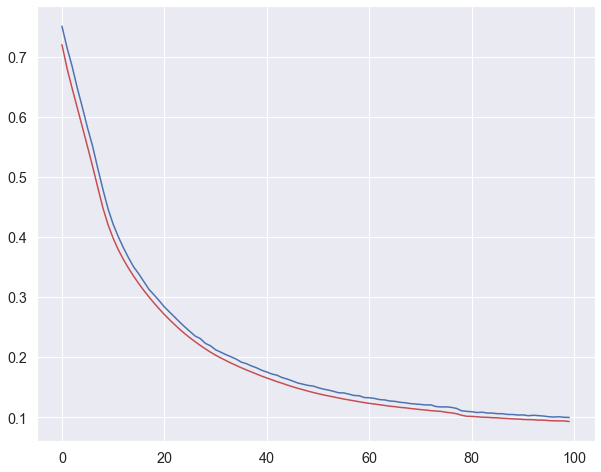

In [118]:
from turtle import color
history = ANN1.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [124]:
# ANN 1  - Lalonde CPS 
# takes apx 7 minutes
ANN1_metrics = pd.DataFrame()
ANN2_metrics = pd.DataFrame()
ANN3_metrics = pd.DataFrame()
ANN4_metrics = pd.DataFrame()

kfold_evaluation_ANN(ANN1,X1,Y1,ANN1_metrics)
kfold_evaluation_ANN(ANN2,X2,Y2,ANN2_metrics)
kfold_evaluation_ANN(ANN3,X3,Y3,ANN3_metrics)
kfold_evaluation_ANN(ANN4,X4,Y4,ANN4_metrics)


Xtrain pre augmentation: (8122, 16)
Ytrain pre augmentation (8122, 1)
Xtrain: (15553, 16)
Ytrain (15553, 1)
Xtest (2031, 16)
Ytest (2031, 1)
Re-initializing module.
Re-initializing criterion.
Re-initializing optimizer.
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8919       0.4989        0.8298  0.2619
      2        0.8232       0.4989        0.7707  0.2402
      3        0.7597       0.4989        0.7111  0.2408
      4        0.7014       0.4989        0.6525  0.2214
      5        0.6411       0.4989        0.5960  0.2318
      6        0.5882       0.4989        0.5462  0.2360
      7        0.5421       0.4989        0.5024  0.2367
      8        0.5021       0.4989        0.4638  0.2224
      9        0.4646       0.4989        0.4295  0.2319
     10        0.4303       0.4989        0.3996  0.2291
     11        0.4010       0.4989        0.3745  0.2242
     12        0.3775       0.4989      

In [125]:
ANN1_metrics.loc['RMSE']=np.sqrt(ANN1_metrics.loc["MSE:"])
ANN2_metrics.loc['RMSE']=np.sqrt(ANN2_metrics.loc["MSE:"])
ANN3_metrics.loc['RMSE']=np.sqrt(ANN3_metrics.loc["MSE:"])
ANN4_metrics.loc['RMSE']=np.sqrt(ANN4_metrics.loc["MSE:"])

ANN1_metrics['avg'] = np.mean(ANN1_metrics,axis=1)
ANN2_metrics['avg'] = np.mean(ANN2_metrics,axis=1)
ANN3_metrics['avg'] = np.mean(ANN3_metrics,axis=1)
ANN4_metrics['avg'] = np.mean(ANN4_metrics,axis=1)

In [126]:
ANN1_metrics

0         1         2         3         4       avg
Accuracy:   0.500000  0.500000  0.500000  0.500000  0.500000  0.500000
Precision:  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
Recall:     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
MSE:        0.027080  0.027573  0.027573  0.027094  0.027094  0.027283
MAE:        0.027080  0.027573  0.027573  0.027094  0.027094  0.027283
R^2:       -0.027834 -0.028354 -0.028354 -0.027848 -0.027848 -0.028048
roc_auc:    0.500000  0.500000  0.500000  0.500000  0.500000  0.500000
F1:         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
logloss:    0.111149  0.133754  0.103232  0.115544  0.124496  0.117635
RMSE        0.164561  0.166050  0.166050  0.164601  0.164601  0.165173

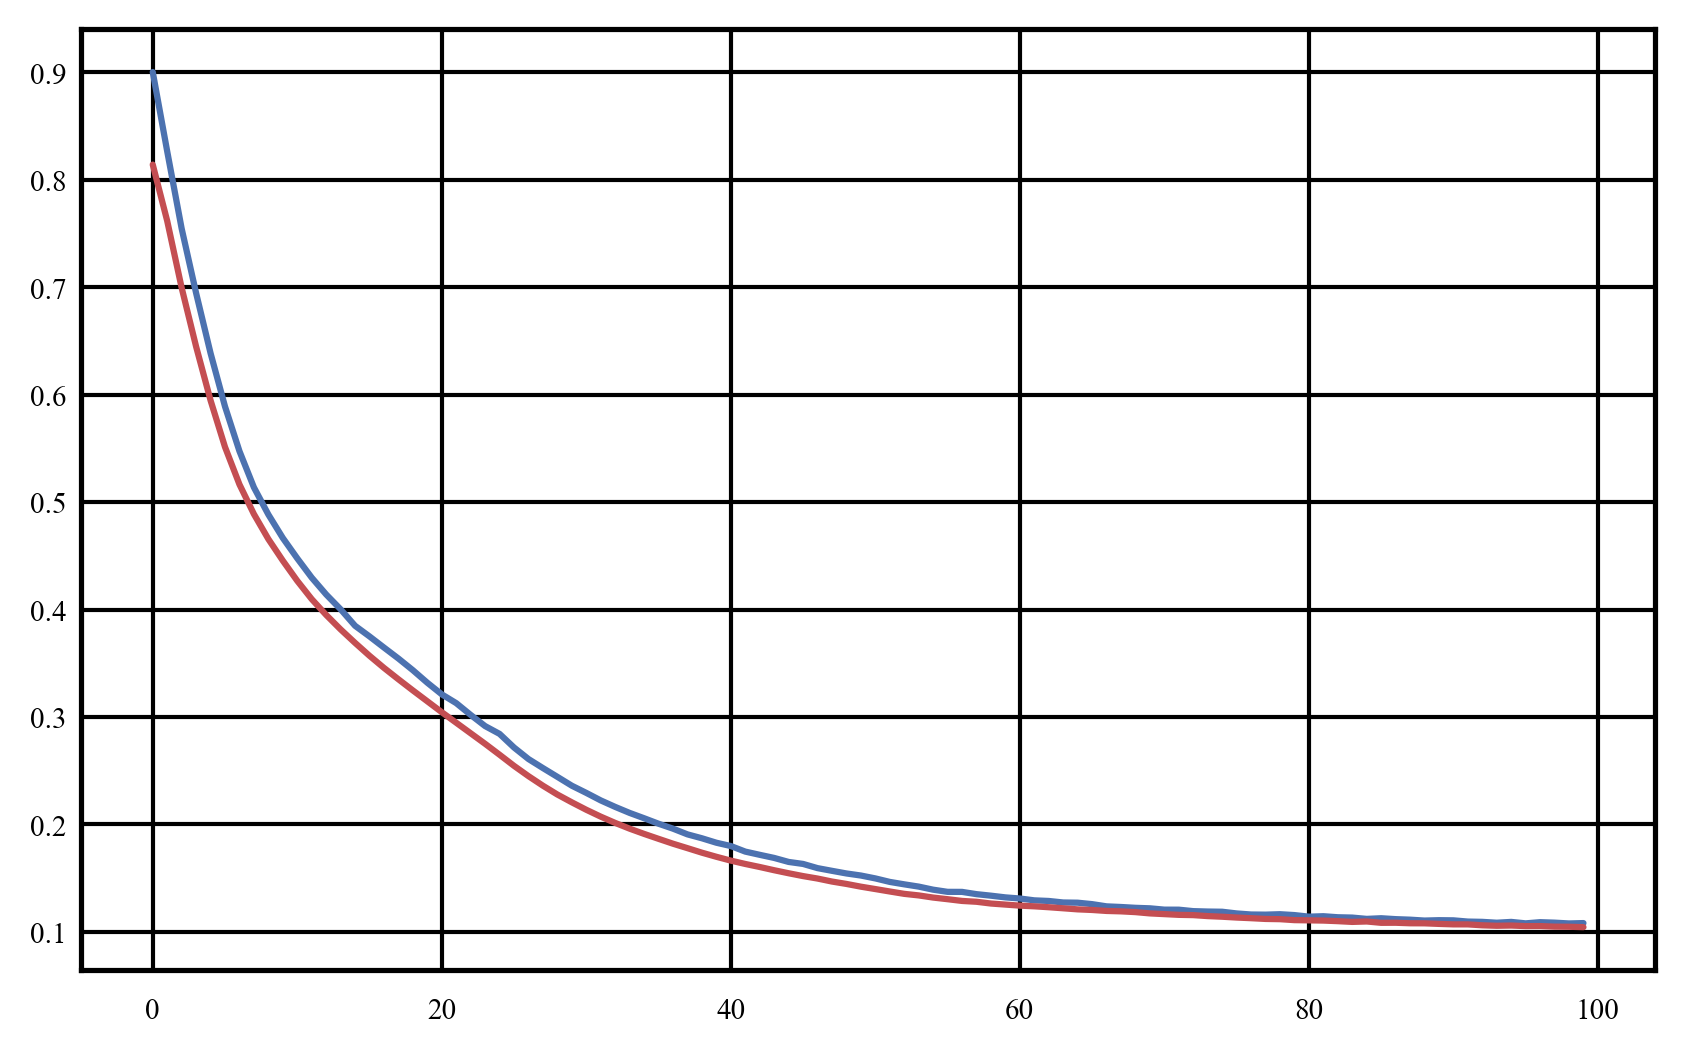

In [127]:
from turtle import color
history = ANN1.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [128]:
ANN2_metrics

0         1         2         3         4       avg
Accuracy:   0.500000  0.500000  0.500000  0.500000  0.500000  0.500000
Precision:  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
Recall:     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
MSE:        0.107692  0.107900  0.105973  0.105973  0.105973  0.106702
MAE:        0.107692  0.107900  0.105973  0.105973  0.105973  0.106702
R^2:       -0.120690 -0.120950 -0.118534 -0.118534 -0.118534 -0.119449
roc_auc:    0.500000  0.500000  0.500000  0.500000  0.500000  0.500000
F1:         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
logloss:    0.315903  0.280006  0.311508  0.304526  0.297708  0.301930
RMSE        0.328165  0.328481  0.325535  0.325535  0.325535  0.326650

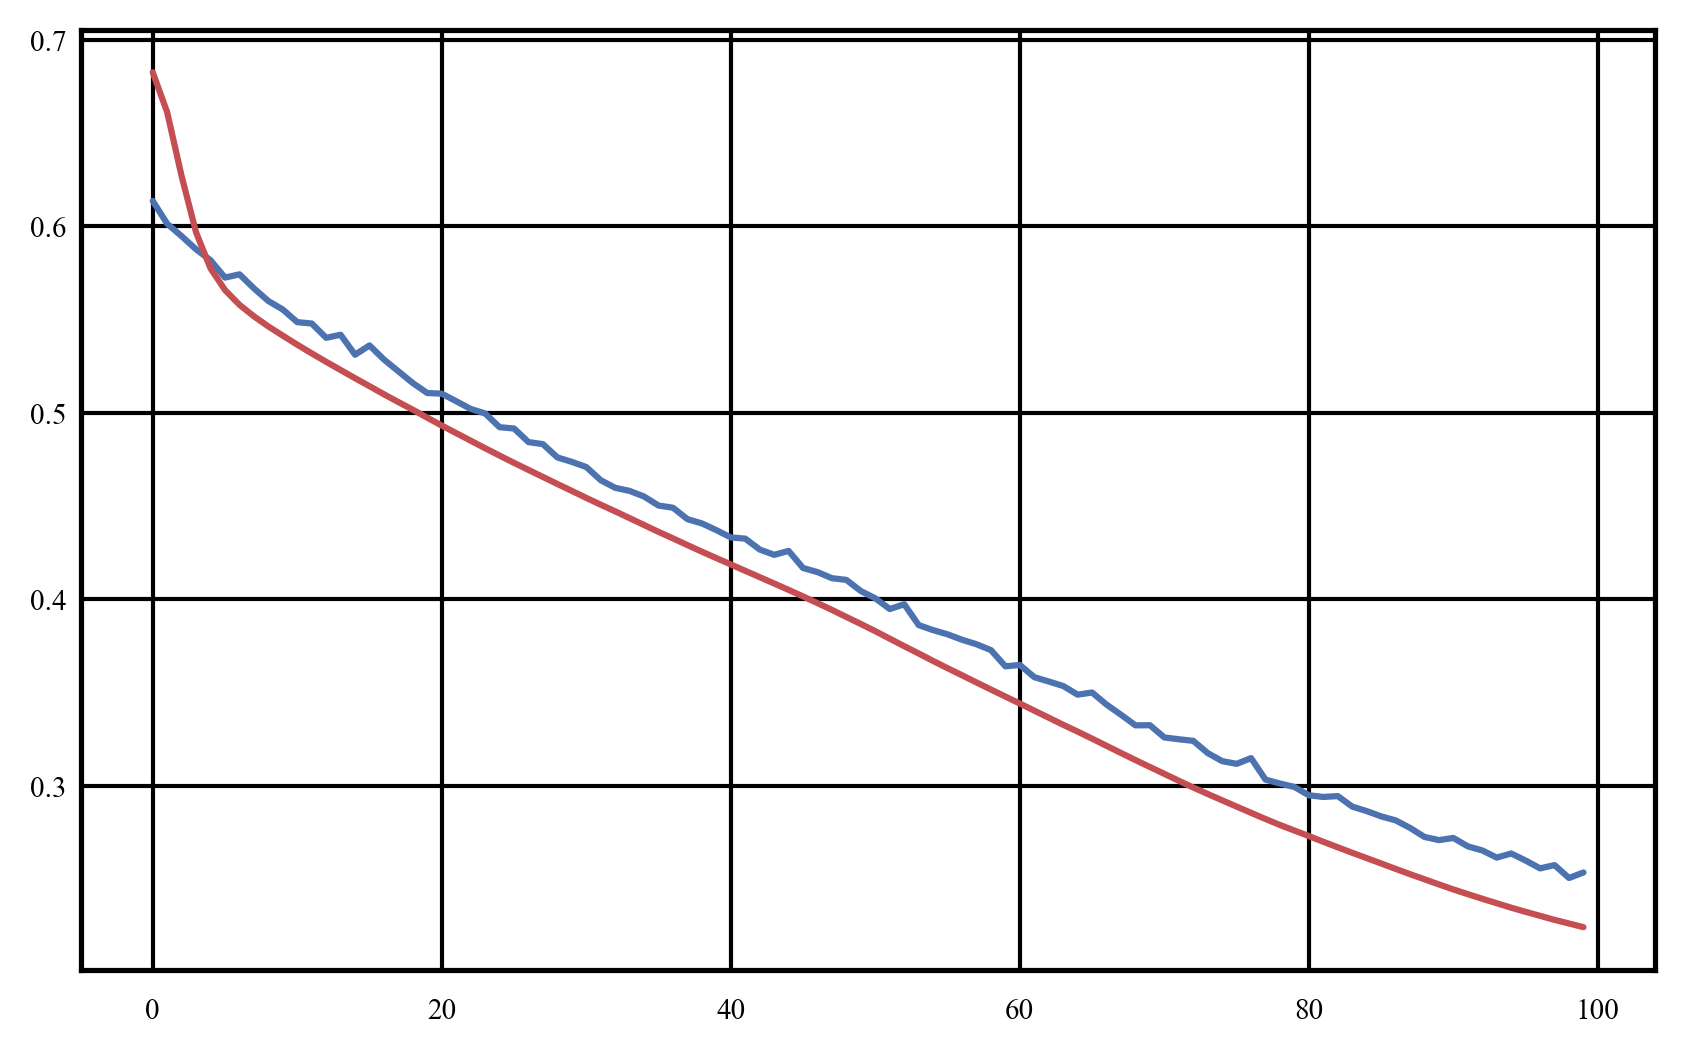

In [130]:
history = ANN2.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [131]:
ANN3_metrics

0         1         2         3         4       avg
Accuracy:   0.500000  0.500000  0.500000  0.500000  0.500000  0.500000
Precision:  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
Recall:     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
MSE:        0.016426  0.016924  0.016924  0.016434  0.016434  0.016628
MAE:        0.016426  0.016924  0.016924  0.016434  0.016434  0.016628
R^2:       -0.016700 -0.017215 -0.017215 -0.016709 -0.016709 -0.016910
roc_auc:    0.500000  0.500000  0.500000  0.500000  0.500000  0.500000
F1:         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
logloss:    0.077342  0.083659  0.085057  0.081615  0.065210  0.078576
RMSE        0.128164  0.130092  0.130092  0.128196  0.128196  0.128948

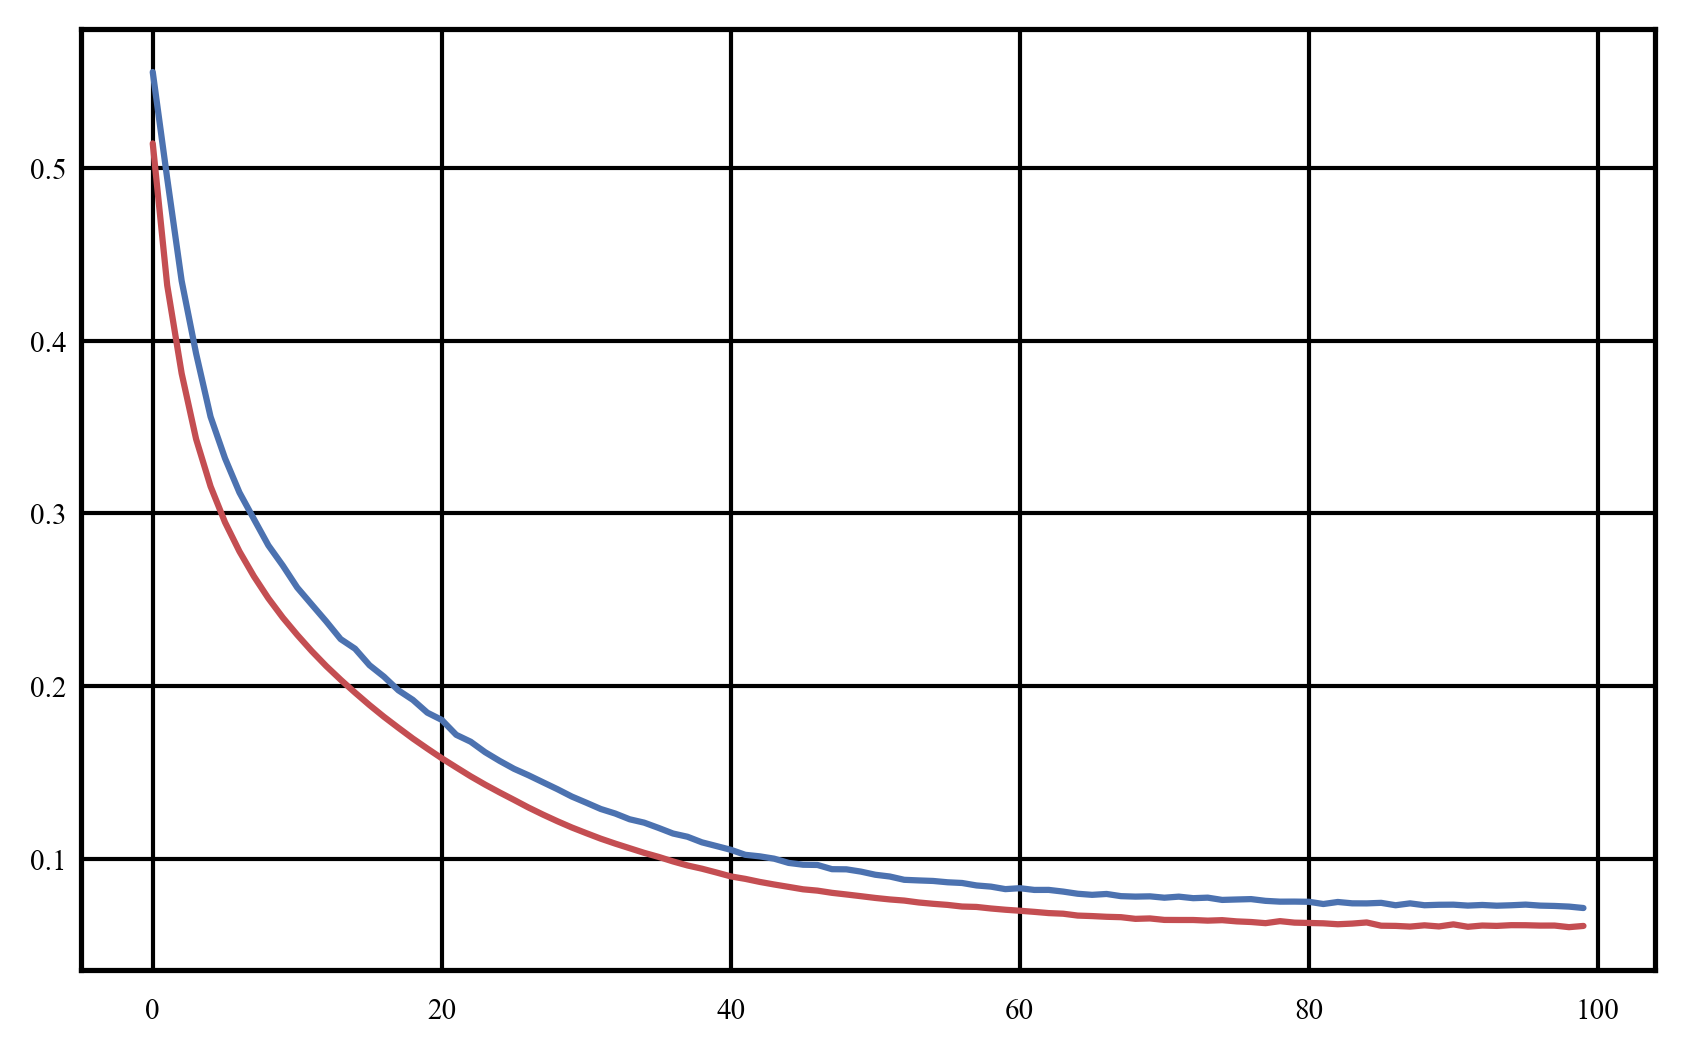

In [132]:
history = ANN3.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

In [133]:
ANN4_metrics

0         1         2         3         4       avg
Accuracy:   0.500000  0.500000  0.500000  0.500000  0.500000  0.500000
Precision:  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
Recall:     0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
MSE:        0.068273  0.066398  0.066398  0.066398  0.068410  0.067176
MAE:        0.068273  0.066398  0.066398  0.066398  0.068410  0.067176
R^2:       -0.073276 -0.071121 -0.071121 -0.071121 -0.073434 -0.072014
roc_auc:    0.500000  0.500000  0.500000  0.500000  0.500000  0.500000
F1:         0.000000  0.000000  0.000000  0.000000  0.000000  0.000000
logloss:    0.286307  0.220202  0.300958  0.264824  0.250855  0.264629
RMSE        0.261291  0.257679  0.257679  0.257679  0.261554  0.259176

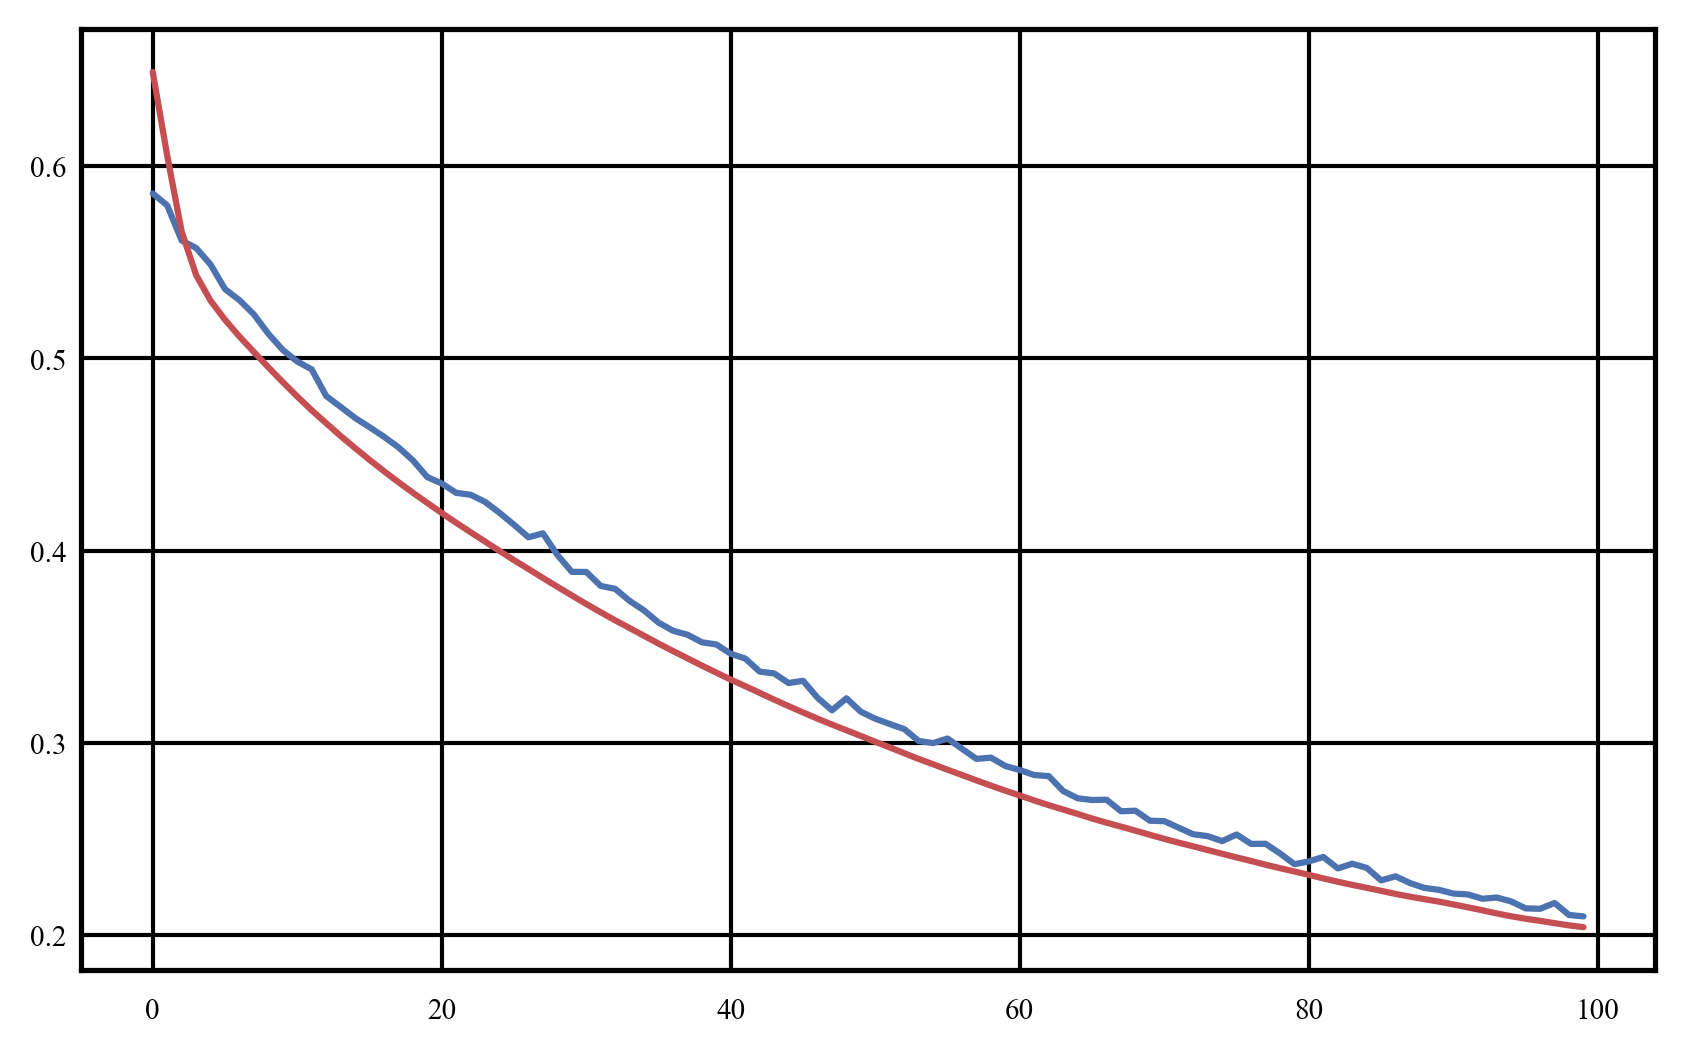

In [134]:
history = ANN4.history
tloss = history[:, 'train_loss']
vloss = history[:, 'valid_loss']
plt.plot(tloss, '-',color='b',label='training')
plt.plot(vloss, '-',color='r', label='validation')

## Inference

In [135]:


def propensity_score_functANN(dataset,model,dataset2):
    
    dataset2.columns = dataset2.columns.str.strip() 
    if 're74' in dataset2.columns: 
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re74','re75','re78']]
    else:
        dataset2 = dataset2[['treat','age','education*','black','hispanic','married','nodegree','re75','re78']]

    treat =  dataset.iloc[:,0]
    dataset =  dataset.iloc[:,1:len(dataset)]
    columns = dataset.columns
    dataset = dataset.to_numpy()
    dataset = dataset.astype(np.float32)
    #Y1 = np.reshape(Y1,(Y1.shape[0],1))
    # Generate propensity score prediction  
    probabilities = model.predict_proba(dataset)
    probabilities = pd.DataFrame(probabilities)
    ps = probabilities # propensity score 
    # merge prediction and existing dataset 
    dataset = pd.DataFrame(dataset)
    dataset.columns = columns
    #dataset_proba = pd.merge(dataset, ps, left_index=True, right_index=True)
    dataset_proba = pd.merge(dataset2, ps, left_index=True, right_index=True)
    dataset_proba.rename(index=int, columns={0:'propensity_score'}, inplace = True) # rename column
    dataset_proba['propensity_logit'] = np.log(dataset_proba['propensity_score'] / (1-dataset_proba['propensity_score']))
    return dataset_proba

In [136]:
# Predict get scores on NSW , CPS and PSID 
# ============ Lalonde Subsample ============ # 
# predict propensity scores
nswCps_lalonde_ps_ANN = propensity_score_functANN(nswCps_lalonde_subset,ANN1,nswCps_lalonde)
nswPsid_lalonde_ps_ANN= propensity_score_functANN(nswPsid_lalonde_subset,ANN2,nswPsid_lalonde)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
#nswCps_lalonde_ps_CART_withRe78 = pd.merge(nswCps_lalonde_ps_CART,nswCps_lalonde_re78,left_index=True, right_index=True)
#nswPsid_lalonde_ps_CART_withRe78 = pd.merge(nswPsid_lalonde_ps_CART,nswPsid_lalonde_re78,left_index=True, right_index=True)
# ============ Dehejia & Wahba sub sample ============ # 
# predict propensity scores
nswCps_dehWab_ps_ANN = propensity_score_functANN(nswCps_dehWab_subset,ANN3,nswCps_dehWab)
nswPsid_dehWab_ps_ANN = propensity_score_functANN(nswPsid_dehWab_subset,ANN4,nswPsid_dehWab)
# Rejoin the original wage covariate to dataframe with estimated propensity scores 
#nswCps_dehWab_ps_CART_withRe78 = pd.merge(nswCps_dehWab_ps_CART,nswCps_dehWab_re78,left_index=True, right_index=True)
#nswPsid_dehWab_ps_CART_withRe78  = pd.merge(nswPsid_dehWab_ps_CART,nswPsid_dehWab_re78,left_index=True, right_index=True)


In [137]:
# save unmatched boost datasets 
nswCps_lalonde_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/ann/unmatched/nswCps_lalonde_ps_unmatched_ANN.csv')
nswPsid_lalonde_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/ann/unmatched/nswPsid_lalonde_ps_unmatched_ANN.csv')
nswCps_dehWab_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/ann/unmatched/nswCps_dehWab_ps_unmatched_ANN.csv')
nswPsid_dehWab_ps_ANN.to_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/ann/unmatched/nswPsid_dehWab_ps_unmatched_ANN.csv')

# Further matching 

In [201]:
# Load matched datasets 
# 1 - nsw lalonde + cps contol
# 2 - nsw lalonde + psid contol
# 3 - nsw dehejia & wahba + cps contol
# 3 - nsw dehejia & wahba + psid contol

# LOGIT 
LOGIT_Matched1 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/nswCps_lalonde_LOGIT_psMatched.csv')
LOGIT_Matched2 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/nswPsid_lalonde_LOGIT_psMatched.csv')
LOGIT_Matched3 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/nswCps_dehWab_LOGIT_psMatched.csv')
LOGIT_Matched4 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/logit/nswPsid_dehWab_LOGIT_psMatched.csv')

# CART 
CART_Matched1 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/nswCps_lalonde_CART_psMatched.csv')
CART_Matched2 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/nswPsid_lalonde_CART_psMatched.csv')
CART_Matched3 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/nswCps_dehWab_CART_psMatched.csv')
CART_Matched4 =pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/cart/nswPsid_dehWab_CART_psMatched.csv')

# Random Forest 
FOREST_Matched1 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/nswCps_lalonde_forest_psMatched.csv')
FOREST_Matched2 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/nswPsid_lalonde_forest_psMatched.csv')
FOREST_Matched3 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/nswCps_dehWab_forest_psMatched.csv')
FOREST_Matched4 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/forest/nswPsid_dehWab_forest_psMatched.csv')

# Boosted trees 
BOOST_Matched1 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/boost/nswCps_lalonde_boost_psMatched.csv')
BOOST_patched2 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/boost/nswPsid_lalonde_boost_psMatched.csv')
BOOST_Matched3 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/boost/nswCps_dehWab_boost_psMatched.csv')
BOOST_Matched4 = pd.read_csv('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/datasets/quasi data/boost/nswPsid_dehWab_boost_psMatched.csv')

# ANN  

## Box plots

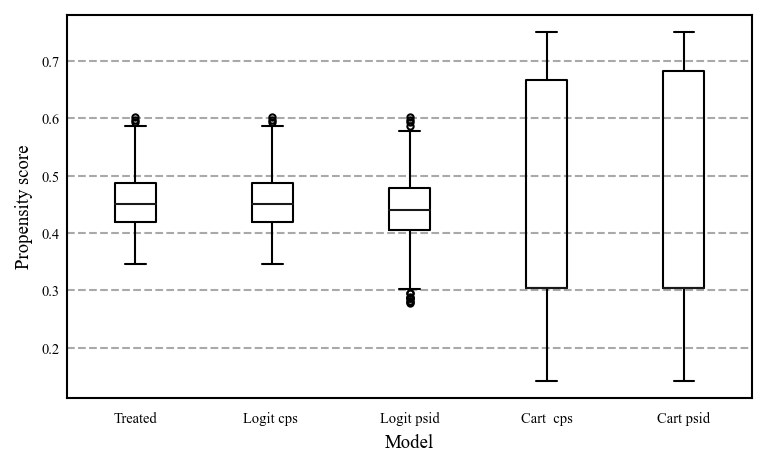

In [120]:
# Box plots of estimated propensity scores across each model - CPS group 

fig, ax = plt.subplots(figsize=(5, 3))

# Neat formatting for plots 
plt.rcParams.update({"figure.dpi": 150}) 
plt.rcParams.update(bundles.neurips2022())
plt.rcParams.update(fonts.neurips2022())
plt.rcParams.update(axes.tick_direction( y="in"))
plt.rcParams.update(axes.color(base="black"))
plt.rcParams.update(figsizes.neurips2022())
plt.rcParams.update(fontsizes.neurips2022())

ax.set_facecolor('white')
# Set boarder colour 
for spine in ax.spines:
    ax.spines[spine].set_color('black')
    ax.spines[spine].set_linewidth(1)

ax.grid(color='darkgrey', axis='y', linestyle='--', linewidth=1, alpha=1)
ax.grid(color='white', axis='x')

# Cusotmise median line 
medianprops = dict(linestyle='-', linewidth = 1, color='k')
boxprops = dict(linewidth = 1)
whiskerprops = dict(linewidth = 1)
capprops = dict(linewidth = 1)

flierprops = {'marker': 'o', 'markersize': 3,'linewidth':1}


treated_propensity_PS = logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==1]

Logit_Cpscomprison_PS = logitNswCps_lalonde['propensity_score'][logitNswCps_lalonde['treat']==0]
Logit_Psidcomprison_PS = logitNswPsid_lalonde['propensity_score'][logitNswPsid_lalonde['treat']==0]

cart_Cpscomprison_PS = cartNswCps_lalonde['propensity_score'][cartNswCps_lalonde['treat']==0]
cart_Psidcomprison_PS = cartNswPsid_lalonde['propensity_score'][cartNswPsid_lalonde['treat']==0]

ax.boxplot([treated_propensity_PS,Logit_Cpscomprison_PS,Logit_Psidcomprison_PS,cart_Cpscomprison_PS,cart_Psidcomprison_PS],
            medianprops=medianprops,
            boxprops = boxprops,
            whiskerprops=whiskerprops,
            capprops = capprops ,
            flierprops = flierprops,
            widths=0.3) 

#ax.set_xlim(0.5,5.5)
#ax.set_ylim(-2000,62000)

plt.xticks([1,2,3,4,5],['Treated', 'Logit cps ','Logit psid','Cart  cps','Cart psid'])


ax.set_xlabel('Model')

ax.set_ylabel('Propensity score')

plt.savefig('/Users/mawuliagamah/gitprojects/causal_inference/causal_inference/Jupyter notebooks/lalonde_notebook_plots/_boxplots.png', bbox_inches='tight')

plt.show()